In [0]:
# Load straight from Unity Catalog
spark_df = spark.table("workspace.default.synthetic_retail_sales_canada_100_k")
# or spark.read.table("workspace.default.synthetic_retail_sales_canada_100_k")

display(spark_df.limit(5))


Transaction_ID,Transaction_Timestamp,Store_Type,Province,Customer_ID,Sex,Age,Ethnic_Background,Preferred_Language,Education,Marital_Status,Annual_Income,Loyalty_Member,Product_ID,Category,Quantity,Unit_Price,Total_Price,Payment_Method
T0000001,2022-02-05T04:14:44.000Z,Suburban,NB,C013253,Male,52,Black,English,No Diploma,Widowed,75048,true,P0109,Outdoor,1,134.1,130.08,Cash
T0000002,2020-06-27T10:09:02.000Z,Urban,SK,C093408,Male,82,European,English,Bachelor+,Married/Common-law,83877,true,P0107,Outdoor,1,39.01,37.84,Credit
T0000003,2022-11-02T18:25:44.000Z,Urban,NB,C111423,Female,31,East Asian,English,Bachelor+,Married/Common-law,45821,true,P0033,Groceries,4,1.72,6.67,Debit
T0000004,2022-07-07T05:31:03.000Z,Online,BC,C018570,Female,28,Other,English,High School,Married/Common-law,53518,false,P0073,Apparel,3,79.74,239.22,Debit
T0000005,2024-08-01T16:08:23.000Z,Online,ON,C102155,Male,43,European,English,No Diploma,Married/Common-law,66654,false,P0042,Electronics,1,61.24,61.24,Debit


In [0]:
from pyspark.sql import functions as F

# Load
df = spark.table("synthetic_retail_sales_canada_100_k")

# Rows, columns, schema
print("Row count:", df.count())
print("Column count:", len(df.columns))
df.printSchema()


Row count: 600000
Column count: 19
root
 |-- Transaction_ID: string (nullable = true)
 |-- Transaction_Timestamp: timestamp (nullable = true)
 |-- Store_Type: string (nullable = true)
 |-- Province: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: long (nullable = true)
 |-- Ethnic_Background: string (nullable = true)
 |-- Preferred_Language: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Annual_Income: long (nullable = true)
 |-- Loyalty_Member: boolean (nullable = true)
 |-- Product_ID: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- Unit_Price: double (nullable = true)
 |-- Total_Price: double (nullable = true)
 |-- Payment_Method: string (nullable = true)



In [0]:
from pyspark.sql.functions import col

# Step 1: Recreate the base DataFrame (if not already loaded)
df = spark.table("workspace.default.synthetic_retail_sales_canada_100_k")

# Step 2: Add Unit_Cost column (70% of Unit_Price)
df = df.withColumn("Unit_Cost", col("Unit_Price") * 0.7)

# Step 3: Add Profit column (Unit_Price - Unit_Cost) × Quantity
df = df.withColumn("Profit", (col("Unit_Price") - col("Unit_Cost")) * col("Quantity"))

# Step 4: Immediately write to a temp view (so no lazy errors)
df.createOrReplaceTempView("retail_with_profit")

# Step 5: Read it back to confirm and display
df_check = spark.sql("""
    SELECT Transaction_ID, Unit_Price, Unit_Cost, Quantity, Profit
    FROM retail_with_profit
    LIMIT 5
""")
display(df_check)





Transaction_ID,Unit_Price,Unit_Cost,Quantity,Profit
T0000001,134.1,93.86999999999999,1,40.230000000000004
T0000002,39.01,27.307,1,11.703
T0000003,1.72,1.204,4,2.064
T0000004,79.74,55.81799999999999,3,71.76600000000002
T0000005,61.24,42.868,1,18.372


In [0]:
from pyspark.sql import functions as F

df = df \
    .withColumn("date",   F.to_date("Transaction_Timestamp")) \
    .withColumn("year",   F.year("Transaction_Timestamp")) \
    .withColumn("month",  F.month("Transaction_Timestamp")) \
    .withColumn("hour",   F.hour("Transaction_Timestamp")) \
    .withColumn("weekday",F.date_format("Transaction_Timestamp","E"))  # Mon, Tue, ...


In [0]:
from pyspark.sql.types import DecimalType

df = df.withColumn("Unit_Price",  F.col("Unit_Price").cast(DecimalType(10,2))) \
       .withColumn("Total_Price", F.col("Total_Price").cast(DecimalType(12,2)))


In [0]:
from pyspark.sql import functions as F

# Count nulls for every column
null_counts = df.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c)
    for c in df.columns
])

print("🧹  Null counts per column")
display(null_counts)


🧹  Null counts per column


Transaction_ID,Transaction_Timestamp,Store_Type,Province,Customer_ID,Sex,Age,Ethnic_Background,Preferred_Language,Education,Marital_Status,Annual_Income,Loyalty_Member,Product_ID,Category,Quantity,Unit_Price,Total_Price,Payment_Method,Unit_Cost,Profit,date,year,month,hour,weekday
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
total = df.count()
distinct = df.dropDuplicates().count()
print("Duplicate rows:", total - distinct)


Duplicate rows: 0


In [0]:
from pyspark.sql import functions as F

total_rows = df.count()

exprs = []
for col_name, dtype in df.dtypes:
    cond = F.col(col_name).isNull()

    if dtype in ("string",):
        # also treat empty or whitespace‑only strings as missing
        cond = cond | (F.trim(F.col(col_name)) == "")
    elif dtype in ("float", "double"):
        cond = cond | F.isnan(F.col(col_name))

    exprs.append(F.count(F.when(cond, col_name)).alias(col_name))

missing_counts = df.select(exprs)
missing_pct    = missing_counts.select([
    (F.col(c) / total_rows * 100).alias(c) for c in missing_counts.columns
])

print("👉 Missing counts (by column)")
display(missing_counts)

print("👉 Missing percentages")
display(missing_pct)

numeric_cols = [c for c,t in df.dtypes if t in ("int","bigint","long","double","float","decimal")]
df.select(numeric_cols).summary(
    "count","mean","stddev","min","25%","50%","75%","max"
).show(truncate=False)




👉 Missing counts (by column)


Transaction_ID,Transaction_Timestamp,Store_Type,Province,Customer_ID,Sex,Age,Ethnic_Background,Preferred_Language,Education,Marital_Status,Annual_Income,Loyalty_Member,Product_ID,Category,Quantity,Unit_Price,Total_Price,Payment_Method,date,year,month,hour,weekday
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


👉 Missing percentages


Transaction_ID,Transaction_Timestamp,Store_Type,Province,Customer_ID,Sex,Age,Ethnic_Background,Preferred_Language,Education,Marital_Status,Annual_Income,Loyalty_Member,Product_ID,Category,Quantity,Unit_Price,Total_Price,Payment_Method,date,year,month,hour,weekday
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


+-------+------------------+------------------+------------------+------------------+-----------------+------------------+
|summary|Age               |Annual_Income     |Quantity          |year              |month            |hour              |
+-------+------------------+------------------+------------------+------------------+-----------------+------------------+
|count  |600000            |600000            |600000            |600000            |600000           |600000            |
|mean   |38.140571666666666|56684.05254       |2.819306666666667 |2022.4152216666666|6.538766666666667|13.118383333333334|
|stddev |13.743739887327152|12489.697631739022|1.4946750960364683|1.4910498559449126|3.46351417957345 |5.7555863238259315|
|min    |18                |11855             |1                 |2020              |1                |0                 |
|25%    |27                |47834             |2                 |2021              |4                |9                 |
|50%    |37     

In [0]:
total_revenue_df = df.agg(F.sum("Total_Price").alias("Total_Revenue_CAD"))
display(total_revenue_df)  # numeric card


Total_Revenue_CAD
9.352436122000675E7


In [0]:
# run this in a notebook cell (install once)
%pip install num2words


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=03974488294556d3aeb713011b827e494c03b19e4edf0271ba1c99816a931fe3
  Stored in directory: /home/spark-426d90b9-f734-4511-8a19-57/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built docopt
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
%restart_python

Year,Revenue_CAD,Revenue_Words
2020,9654263.199999986,"ninety-six thousand, five hundred and forty-two Canadian dollars, sixty-three cents"
2021,1.7503824319999732E7,"one hundred and seventy-five thousand and thirty-eight Canadian dollars, twenty-four cents"
2022,1.8870938850000296E7,"one hundred and eighty-eight thousand, seven hundred and nine Canadian dollars, thirty-eight cents"
2023,1.9398719800000247E7,"one hundred and ninety-three thousand, nine hundred and eighty-seven Canadian dollars, nineteen cents"
2024,1.9817776470000803E7,"one hundred and ninety-eight thousand, one hundred and seventy-seven Canadian dollars, seventy-six cents"
2025,8278838.57999976,"eighty-two thousand, seven hundred and eighty-eight Canadian dollars, thirty-eight cents"


<Axes: title={'center': 'Revenue by Year'}, xlabel='Year'>

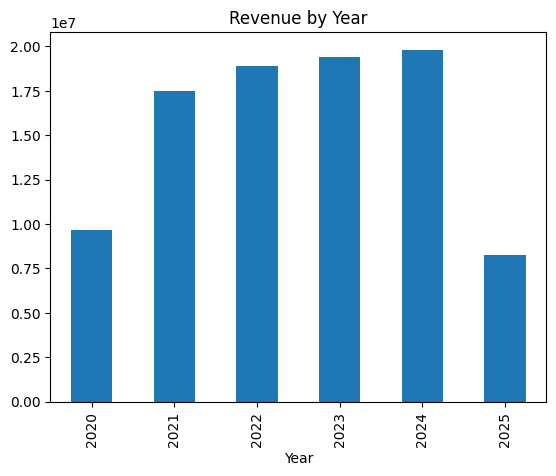

In [0]:
from num2words import num2words
from pyspark.sql import functions as F, types as T

# --- revenue per year Frame ---
rev_year = (
    df.groupBy(F.year("Transaction_Timestamp").alias("Year"))
      .agg(F.sum("Total_Price").alias("Revenue_CAD"))
      .orderBy("Year")
)

# --- add spelled‑out column (PySpark UDF) ---
spell_udf = F.udf(lambda x: num2words(int(x), to="currency", lang="en").replace("euro", "Canadian dollars"),
                  T.StringType())

rev_year = rev_year.withColumn("Revenue_Words", spell_udf("Revenue_CAD"))

display(rev_year)          # table with numeric + words

# --- quick bar plot with pandas (numbers only) ---
pd_rev_year = rev_year.select("Year", "Revenue_CAD").toPandas()
pd_rev_year.plot(kind="bar", x="Year", y="Revenue_CAD",
                 legend=False, title="Revenue by Year")


/databricks/python/lib/python3.11/site-packages/pyspark/sql/connect/expressions.py:1017: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


Year,Revenue_CAD,Revenue_Words,YoY_%
2020,9654263.199999986,"ninety-six thousand, five hundred and forty-two Canadian dollars, sixty-three cents",null
2021,1.7503824319999732E7,"one hundred and seventy-five thousand and thirty-eight Canadian dollars, twenty-four cents",81.30668241984284
2022,1.8870938850000296E7,"one hundred and eighty-eight thousand, seven hundred and nine Canadian dollars, thirty-eight cents",7.810376206978434
2023,1.9398719800000247E7,"one hundred and ninety-three thousand, nine hundred and eighty-seven Canadian dollars, nineteen cents",2.7967922221312405
2024,1.9817776470000803E7,"one hundred and ninety-eight thousand, one hundred and seventy-seven Canadian dollars, seventy-six cents",2.1602284806472203
2025,8278838.57999976,"eighty-two thousand, seven hundred and eighty-eight Canadian dollars, thirty-eight cents",-58.22518942762389


<Axes: title={'center': 'YoY Revenue Growth (%)'}, xlabel='Year'>

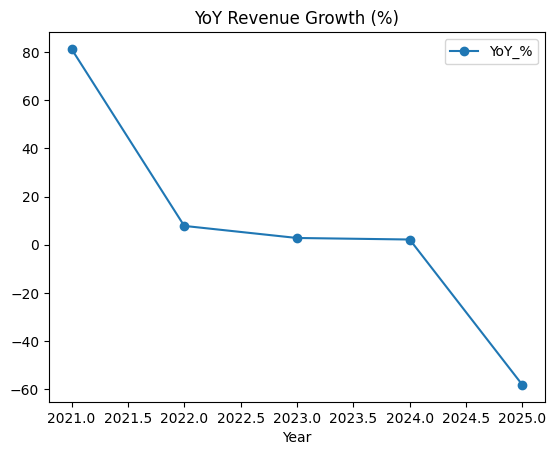

/databricks/python/lib/python3.11/site-packages/pyspark/sql/connect/expressions.py:1017: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


In [0]:
from pyspark.sql import Window as W
w = W.orderBy("Year")
rev_yoy = rev_year.withColumn(
    "YoY_%", 
    (F.col("Revenue_CAD") - F.lag("Revenue_CAD").over(w)) / F.lag("Revenue_CAD").over(w) * 100
)
display(rev_yoy)

# line plot
pd_rev_yoy = rev_yoy.toPandas()
pd_rev_yoy.plot(kind="line", x="Year", y="YoY_%", marker="o", title="YoY Revenue Growth (%)")


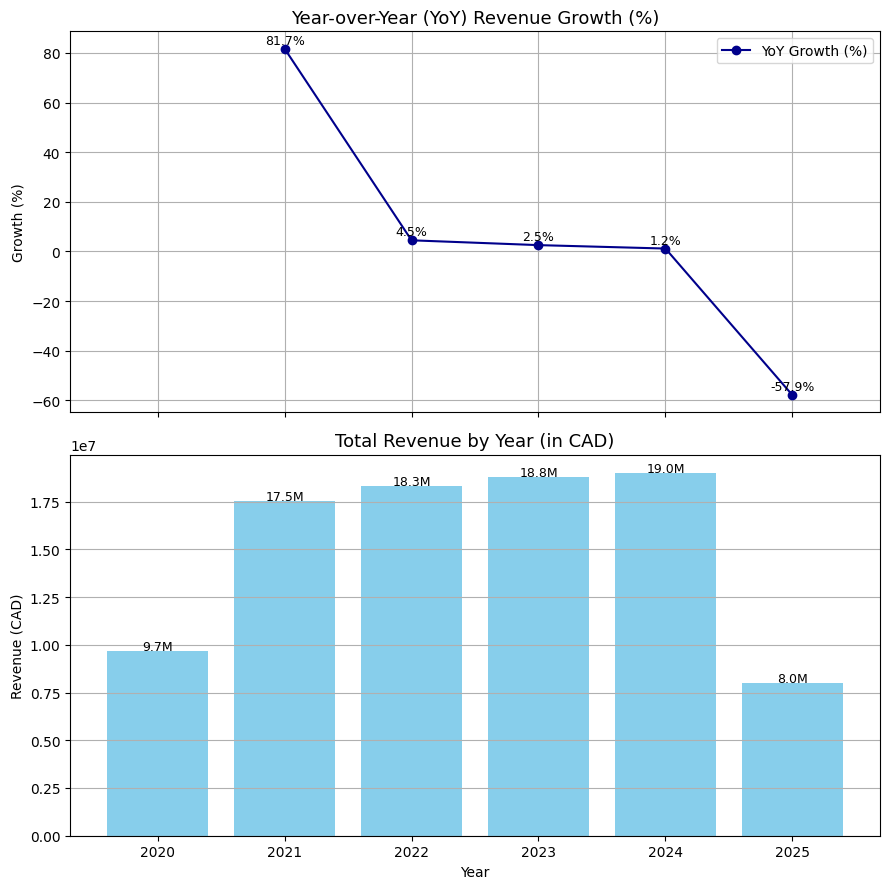

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample DataFrame (replace with your actual data)
data = {
    'Year': [2020, 2021, 2022, 2023, 2024, 2025],
    'Revenue': [9654321, 17543219, 18328450, 18793285, 19010321, 8001432]
}
df = pd.DataFrame(data)

# Calculate Year-over-Year (YoY) Percentage Change
df['YoY_%'] = df['Revenue'].pct_change() * 100

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 9), sharex=True)

# --- Plot 1: YoY % Growth
ax1.plot(df['Year'], df['YoY_%'], marker='o', color='darkblue', label='YoY Growth (%)')
ax1.set_title('Year-over-Year (YoY) Revenue Growth (%)', fontsize=13)
ax1.set_ylabel('Growth (%)')
ax1.grid(True)
ax1.legend()

# Add labels to each point
for i in range(1, len(df)):
    ax1.text(df['Year'][i], df['YoY_%'][i] + 2, f"{df['YoY_%'][i]:.1f}%", ha='center', fontsize=9)

# --- Plot 2: Revenue by Year
bars = ax2.bar(df['Year'], df['Revenue'], color='skyblue')
ax2.set_title('Total Revenue by Year (in CAD)', fontsize=13)
ax2.set_xlabel('Year')
ax2.set_ylabel('Revenue (CAD)')
ax2.grid(axis='y')

# Add labels above bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + 50000, f"{height/1e6:.1f}M", ha='center', fontsize=9)

plt.tight_layout()
plt.show()


In [0]:
from pyspark.sql.functions import year, sum as _sum

# Step 1: Extract Year and calculate total profit per year
profit_year_df = df.withColumn("Year", year("Transaction_Timestamp")) \
                   .groupBy("Year") \
                   .agg(_sum("Profit").alias("Total_Profit")) \
                   .orderBy("Year")

# Step 2: Convert to pandas for plotting
profit_pdf = profit_year_df.toPandas()
profit_pdf["Profit_Growth_%"] = profit_pdf["Total_Profit"].pct_change() * 100

# Display the values
display(profit_pdf)


Year,Total_Profit,Profit_Growth_%
2020,2933762.727000063,null
2021,5318259.219000005,81.27775535679478
2022,5734182.215999816,7.820660480667896
2023,5894785.956000015,2.8008133322320106
2024,6021499.566000191,2.149587973948397
2025,2515804.9260000875,-58.219627877990156


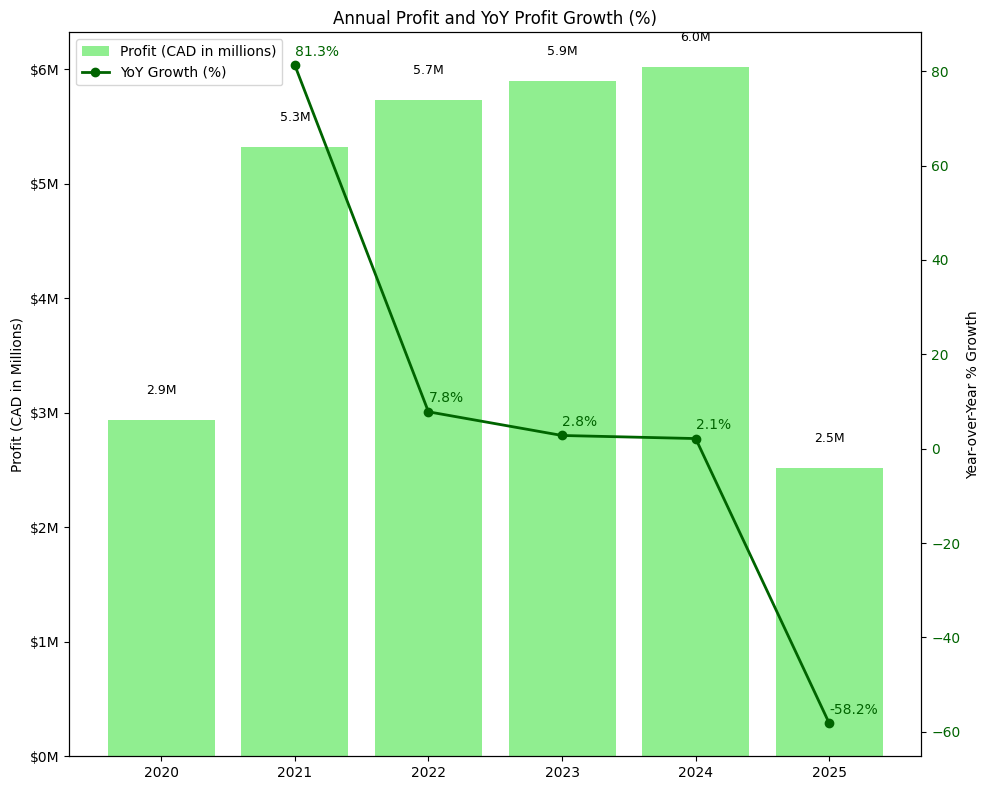

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

# Convert profit to millions for plotting
profit_pdf["Profit_Millions"] = profit_pdf["Total_Profit"] / 1e6

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 8))

# Bar plot for Profit
bars = ax1.bar(profit_pdf["Year"], profit_pdf["Profit_Millions"], color="lightgreen", label="Profit (CAD in millions)")
ax1.set_ylabel("Profit (CAD in Millions)")
ax1.set_title("Annual Profit and YoY Profit Growth (%)")
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x:.0f}M'))

# Add value labels on bars
for bar, val in zip(bars, profit_pdf["Profit_Millions"]):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2,
             f"{val:.1f}M", ha='center', va='bottom', fontsize=9)

# Line plot for YoY Profit Growth
ax2 = ax1.twinx()
ax2.plot(profit_pdf["Year"], profit_pdf["Profit_Growth_%"], color="darkgreen", marker="o", linewidth=2, label="YoY Growth (%)")
ax2.set_ylabel("Year-over-Year % Growth")
ax2.tick_params(axis="y", labelcolor="darkgreen")

# Annotate YoY % values
for x, y in zip(profit_pdf["Year"], profit_pdf["Profit_Growth_%"]):
    if pd.notna(y):
        ax2.annotate(f"{y:.1f}%", (x, y + 2), color="darkgreen")

# Combine legends
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc="upper left")

plt.tight_layout()
plt.show()


In [0]:
from pyspark.sql import functions as F

rev_full = (
    df.groupBy(F.year("Transaction_Timestamp").alias("Year"))
      .agg(F.sum("Total_Price").alias("Revenue_CAD"))
)

# scale the 2025 partial data
run_rate = rev_full.filter("Year = 2025").first()["Revenue_CAD"]
annualised_2025 = run_rate * (12/5)  # Jan‑May to full year

print(f"Annualised 2025 estimate: {annualised_2025:,.0f} CAD")


Annualised 2025 estimate: 19,869,213 CAD


Year_Qtr,Revenue_CAD
2020‑2,1342938.2399999928
2020‑3,4188764.740000036
2020‑4,4122560.2200000086
2021‑1,4255089.839999976
2021‑2,4303651.109999954
2021‑3,4505171.059999957
2021‑4,4439912.309999934
2022‑1,4750352.849999978
2022‑2,4554702.560000015
2022‑3,4722887.639999966


<Axes: title={'center': 'Revenue by Quarter'}, xlabel='Year_Qtr'>

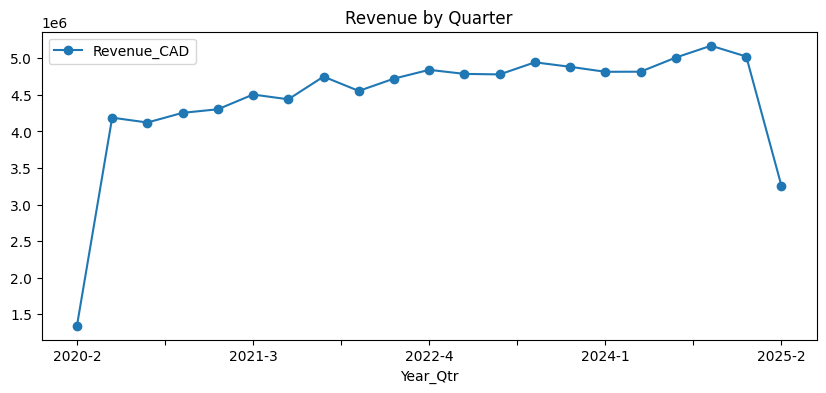

In [0]:
rev_qtr = (
    df.groupBy(
        F.concat_ws("‑", F.year("Transaction_Timestamp"), F.quarter("Transaction_Timestamp"))
          .alias("Year_Qtr")
    )
    .agg(F.sum("Total_Price").alias("Revenue_CAD"))
    .orderBy("Year_Qtr")
)
display(rev_qtr)

pd_rev_qtr = rev_qtr.toPandas()
pd_rev_qtr.plot(kind="line", x="Year_Qtr", y="Revenue_CAD", marker="o", figsize=(10,4),
                title="Revenue by Quarter")


Year,Quarter,Revenue_CAD
2020,2,1342938.2399999928
2020,3,4188764.740000036
2020,4,4122560.2200000086
2021,1,4255089.839999976
2021,2,4303651.109999954
2021,3,4505171.059999957
2021,4,4439912.309999934
2022,1,4750352.849999978
2022,2,4554702.560000015
2022,3,4722887.639999966


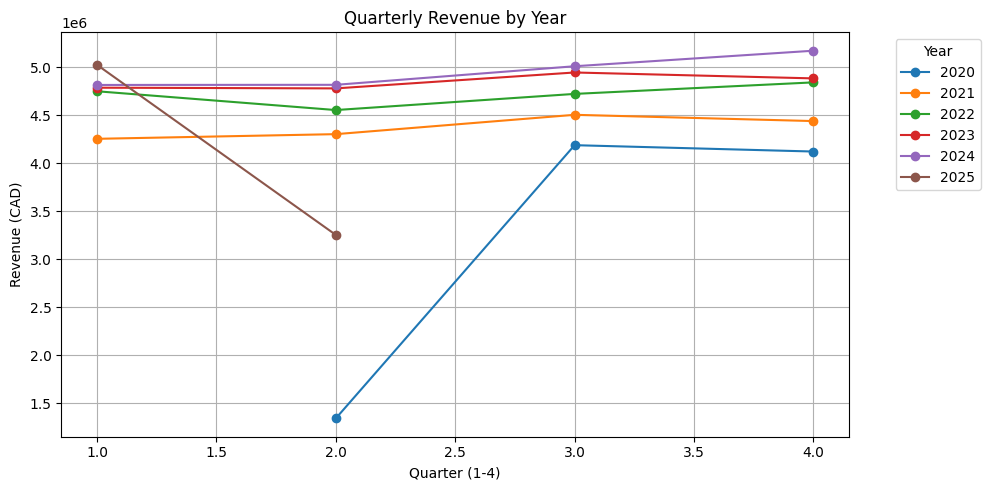

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Step 1: Create Year and Quarter columns
rev_qtr = (
    df.withColumn("Year",    F.year("Transaction_Timestamp"))
      .withColumn("Quarter", F.quarter("Transaction_Timestamp"))
      .groupBy("Year", "Quarter")
      .agg(F.sum("Total_Price").alias("Revenue_CAD"))
      .orderBy("Year", "Quarter")
)

display(rev_qtr)

# Step 2: Convert to pandas for plotting
pd_rev_qtr = rev_qtr.toPandas()

# Step 3: Pivot the table
pivot = pd_rev_qtr.pivot(index="Quarter", columns="Year", values="Revenue_CAD").sort_index()

# Step 4: Plot
pivot.plot(marker="o", figsize=(10,5))
plt.title("Quarterly Revenue by Year")
plt.xlabel("Quarter (1‑4)")
plt.ylabel("Revenue (CAD)")
plt.grid(True)
plt.legend(title="Year", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()



Year,Month,Revenue_CAD
2020,6,1342938.2399999928
2020,7,1459091.859999992
2020,8,1413923.9399999925
2020,9,1315748.9399999941
2020,10,1332745.6299999896
2020,11,1301820.4599999925
2020,12,1487994.129999987
2021,1,1486513.300000001
2021,2,1353308.4500000014
2021,3,1415268.089999999


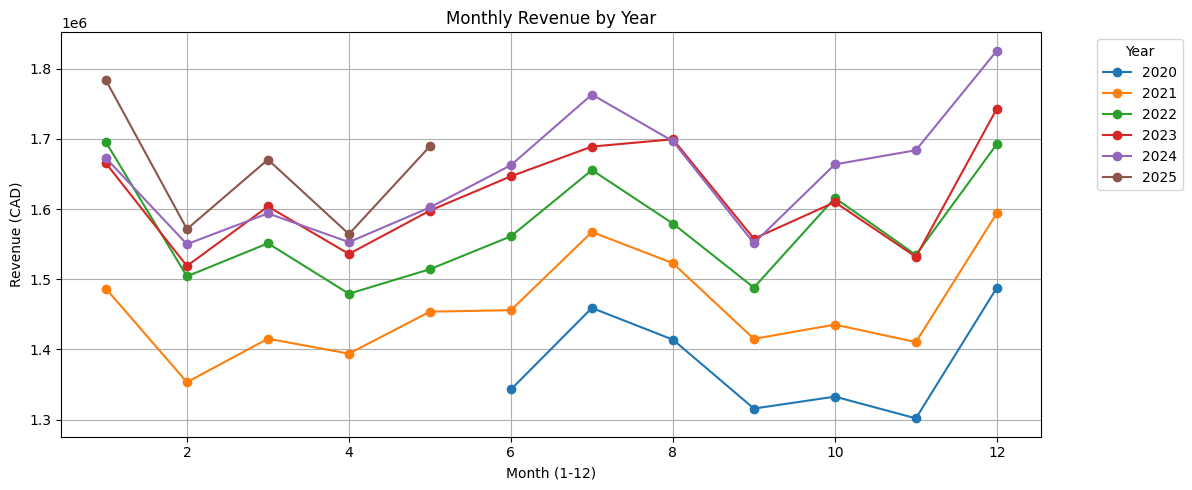

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# 1️⃣ Aggregate revenue by Year + Month
rev_month = (
    df.withColumn("Year",  F.year("Transaction_Timestamp"))
      .withColumn("Month", F.month("Transaction_Timestamp"))
      .groupBy("Year", "Month")
      .agg(F.sum("Total_Price").alias("Revenue_CAD"))
      .orderBy("Year", "Month")
)

display(rev_month)   # optional tabular view

# 2️⃣ Convert to pandas & pivot so each year is a separate line
pd_rev_month = rev_month.toPandas()
pivot_month  = pd_rev_month.pivot(index="Month", columns="Year", values="Revenue_CAD").sort_index()

# 3️⃣ Plot
pivot_month.plot(marker="o", figsize=(12,5))
plt.title("Monthly Revenue by Year")
plt.xlabel("Month (1‑12)")
plt.ylabel("Revenue (CAD)")
plt.grid(True)
plt.legend(title="Year", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()


Day_Type,Revenue_CAD
Weekday,6.3894993740005136E7
Weekend,2.962936748000083E7


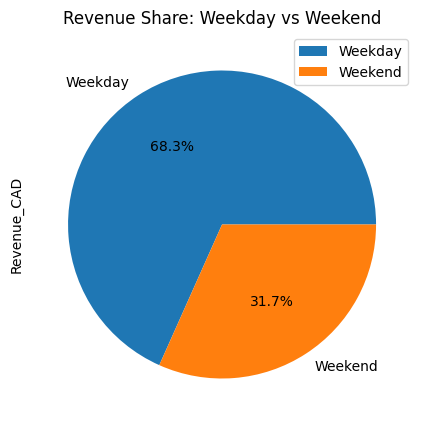

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-5525566162013220>, line 21
     18 pd_rev_dt = rev_daytype.toPandas().set_index("Day_Type")
     19 pd_rev_dt.plot(kind="pie", y="Revenue_CAD", autopct="%1.1f%%",
     20                figsize=(5,5), title="Revenue Share: Weekday vs Weekend")
---> 21 plt.ylabel("")
     22 plt.tight_layout()

NameError: name 'plt' is not defined

In [0]:
# 1️⃣  Label each transaction as Weekday or Weekend
df_w = df.withColumn(
    "Day_Type",
    F.when(F.dayofweek("Transaction_Timestamp").isin(7, 1), F.lit("Weekend"))  # 1=Sunday, 7=Saturday in Spark
     .otherwise(F.lit("Weekday"))
)

# 2️⃣  Revenue by Day_Type
rev_daytype = (
    df_w.groupBy("Day_Type")
        .agg(F.sum("Total_Price").alias("Revenue_CAD"))
        .orderBy(F.desc("Revenue_CAD"))
)

display(rev_daytype)

# 3️⃣  Plot a pie chart
pd_rev_dt = rev_daytype.toPandas().set_index("Day_Type")
pd_rev_dt.plot(kind="pie", y="Revenue_CAD", autopct="%1.1f%%",
               figsize=(5,5), title="Revenue Share: Weekday vs Weekend")
plt.ylabel("")
plt.tight_layout()


Year,count
2020,68491
2021,121043
2022,121584
2023,119938
2024,119612
2025,49332


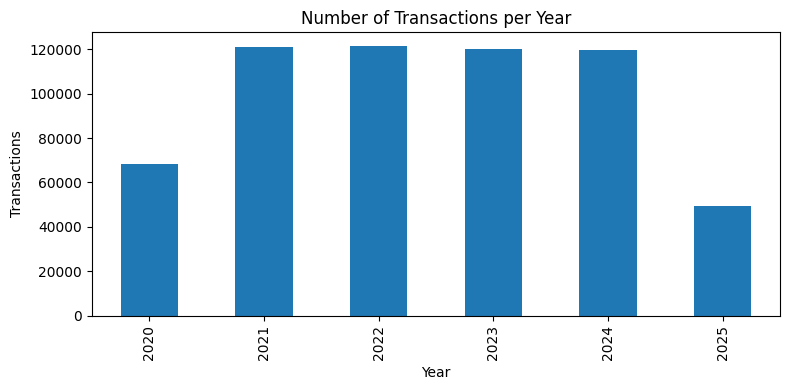

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# 1️⃣  Transaction count per year
tx_year = (
    df.groupBy(F.year("Transaction_Timestamp").alias("Year"))
      .count()
      .orderBy("Year")
)

# 2️⃣  Show the table in Databricks UI
display(tx_year)

# 3️⃣  Plot as a bar chart
pd_tx_year = tx_year.toPandas()

pd_tx_year.plot(kind="bar", x="Year", y="count", legend=False,
                title="Number of Transactions per Year", figsize=(8,4))
plt.ylabel("Transactions")
plt.tight_layout()


Year,Avg_Revenue_per_Txn
2020,140.95666875939884
2021,144.60831539204855
2022,155.20906410383188
2023,161.73956377461894
2024,165.68384835970306
2025,167.81883118462173


<Axes: title={'center': 'Avg\xa0Basket\xa0Size by Year'}, xlabel='Year'>

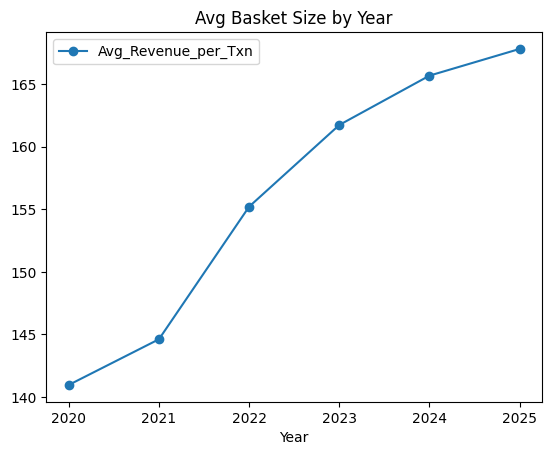

In [0]:
avg_tx_year = (
    df.groupBy(F.year("Transaction_Timestamp").alias("Year"))
      .agg(F.avg("Total_Price").alias("Avg_Revenue_per_Txn"))
      .orderBy("Year")
)
display(avg_tx_year)

avg_tx_year.toPandas().plot(kind="line", x="Year", y="Avg_Revenue_per_Txn",
                            marker="o", title="Avg Basket Size by Year")


Province,Revenue_CAD
ON,3.609373447000097E7
QC,2.136525180000062E7
BC,1.2720013700000053E7
AB,1.0812376090000013E7
MB,3384884.189999963
SK,2844773.99999998
NS,2465599.0899999756
NB,1907890.4699999925
NL,1311374.6699999992
PE,347999.16000000015


<Axes: title={'center': 'Revenue by Province'}, xlabel='Province'>

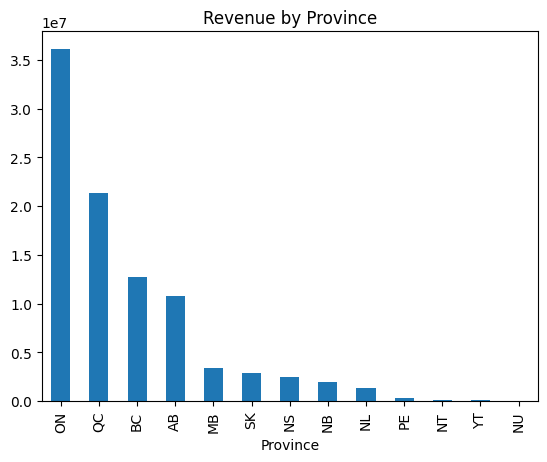

In [0]:
rev_prov = (
    df.groupBy("Province")
      .agg(F.sum("Total_Price").alias("Revenue_CAD"))
      .orderBy(F.desc("Revenue_CAD"))
)
display(rev_prov)

rev_prov.toPandas().plot(kind="bar", x="Province", y="Revenue_CAD", legend=False,
                         title="Revenue by Province")


Store_Type,Revenue_CAD
Suburban,5.984266847000333E7
Online,1.7229594030000377E7
Urban,1.6452098720000224E7


<Axes: title={'center': 'Revenue Share by Store Type'}, ylabel='Revenue_CAD'>

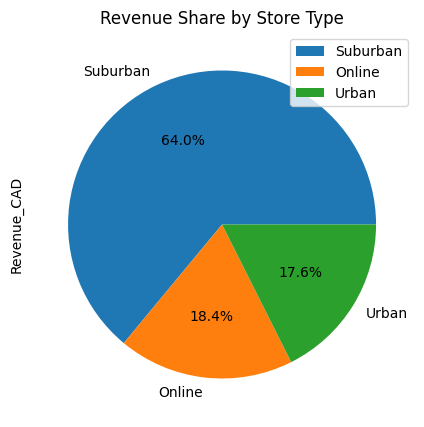

In [0]:
rev_store = (
    df.groupBy("Store_Type")
      .agg(F.sum("Total_Price").alias("Revenue_CAD"))
)
display(rev_store)

rev_store.toPandas().set_index("Store_Type").plot(kind="pie", y="Revenue_CAD",
                                                  autopct="%1.1f%%", figsize=(5,5),
                                                  title="Revenue Share by Store Type")

Store_Type,Profit_CAD
Suburban,1.8184079222998943E7
Online,5235074.001000058
Urban,4999141.3860000055


<Axes: title={'center': 'Profit Share by Store Type'}, ylabel='Profit_CAD'>

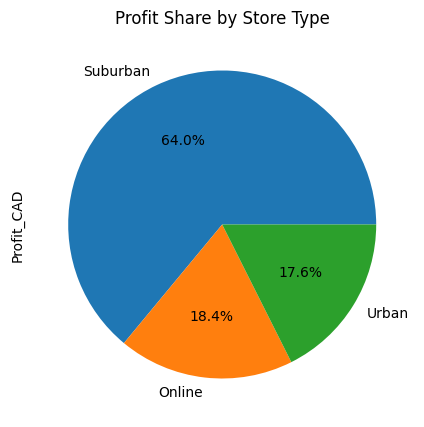

In [0]:
from pyspark.sql import functions as F

# Step 1: Group by Store_Type and sum Profit
profit_store = (
    df.groupBy("Store_Type")
      .agg(F.sum("Profit").alias("Profit_CAD"))
)

# Step 2: Display in notebook
display(profit_store)

# Step 3: Convert to pandas and plot pie chart
profit_store.toPandas().set_index("Store_Type").plot(
    kind="pie",
    y="Profit_CAD",
    autopct="%1.1f%%",
    figsize=(5, 5),
    title="Profit Share by Store Type",
    legend=False
)


Year,Store_Type,Revenue_CAD
2020,Online,1164530.8199999908
2020,Suburban,6678036.500000027
2020,Urban,1811695.8799999848
2021,Online,2633623.95999999
2021,Suburban,1.165626525999987E7
2021,Urban,3213935.099999966
2022,Online,3148985.1999999704
2022,Suburban,1.229145837000027E7
2022,Urban,3430495.2799999956
2023,Online,3895878.709999956


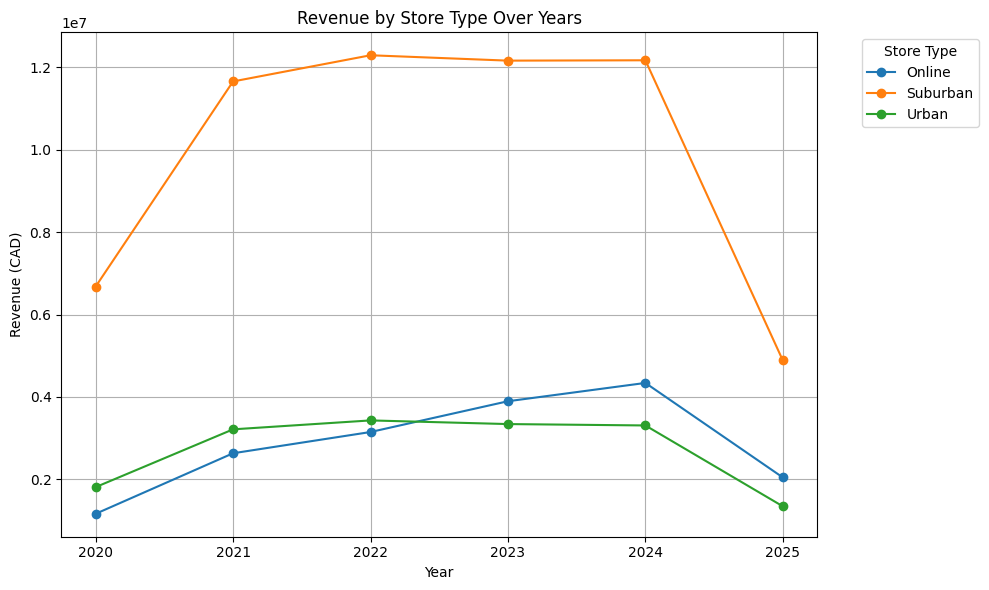

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# 1️⃣  Make sure a Year column exists
df_y = df.withColumn("Year", F.year("Transaction_Timestamp"))

# 2️⃣  Revenue by Store_Type & Year
rev_store_year = (
    df_y.groupBy("Year", "Store_Type")
        .agg(F.sum("Total_Price").alias("Revenue_CAD"))
        .orderBy("Year", "Store_Type")
)

display(rev_store_year)     # interactive Spark table

# 3️⃣  Pivot to have each store type as a separate series
pd_rev_store = rev_store_year.toPandas()
pivot_store   = pd_rev_store.pivot(index="Year", columns="Store_Type", values="Revenue_CAD").sort_index()

# 4️⃣  Plot
pivot_store.plot(marker="o", figsize=(10,6))
plt.title("Revenue by Store Type Over Years")
plt.xlabel("Year")
plt.ylabel("Revenue (CAD)")
plt.grid(True)
plt.legend(title="Store Type", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()


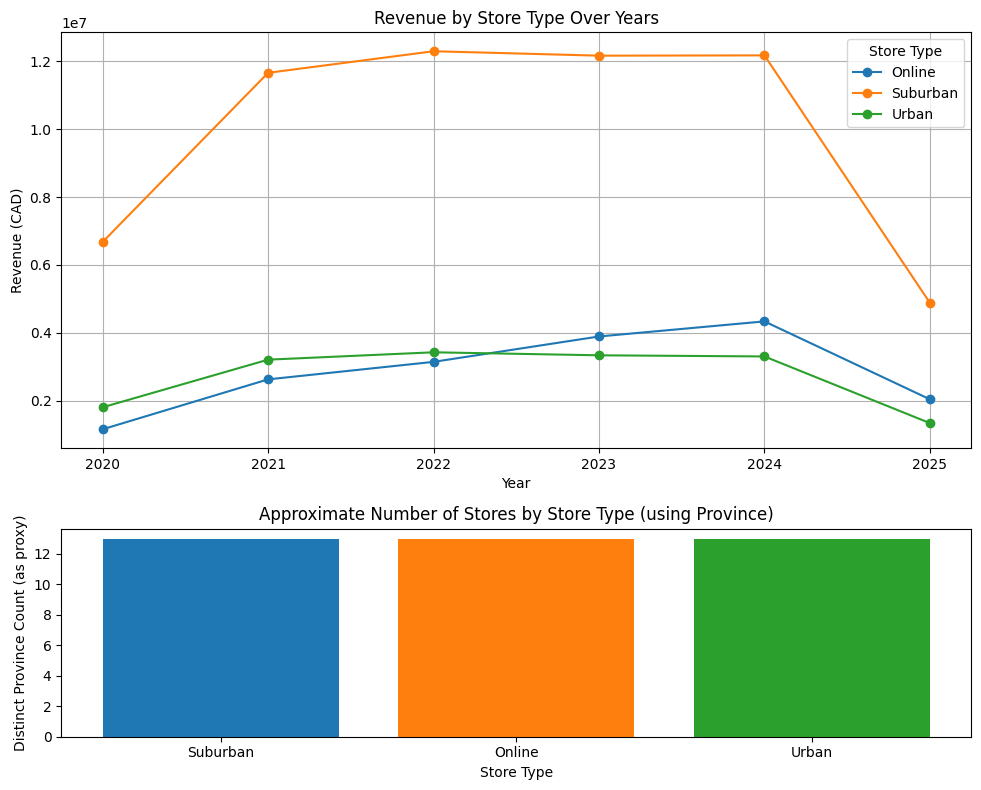

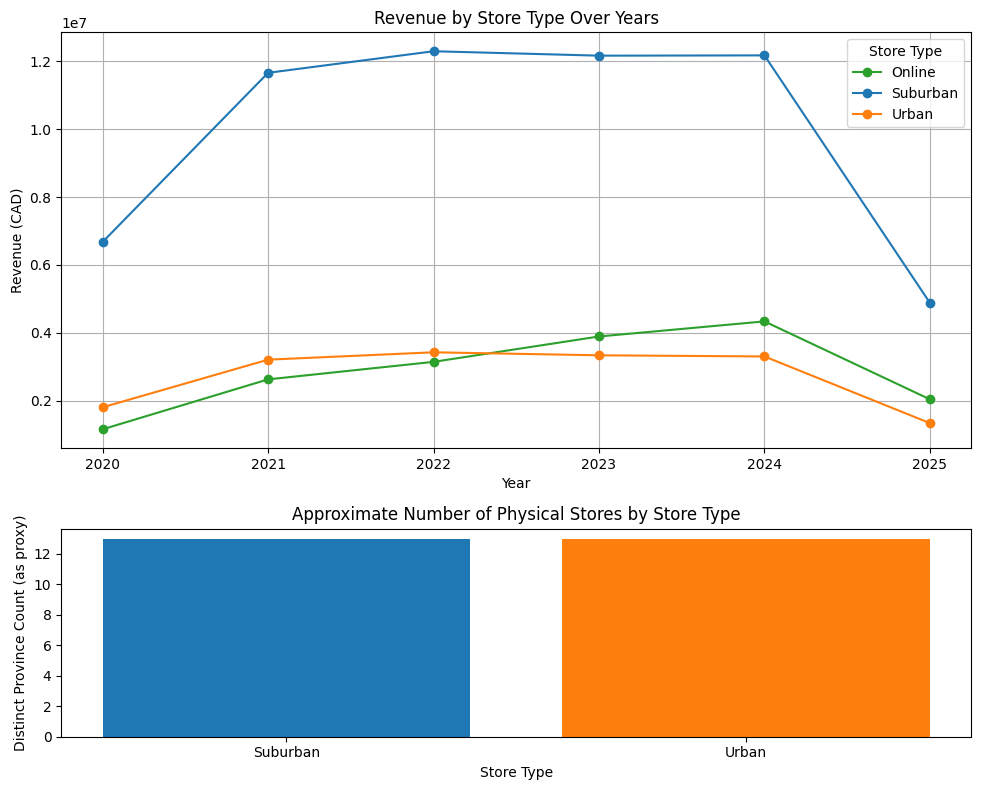

Category,Revenue_CAD
Outdoor,3.314173342999985E7
Electronics,1.8286727430001043E7
Apparel,1.4685625400000239E7
Home Goods,1.3737436960000075E7
Toys,6620836.8199998755
Pharmacy,6140242.029999936
Groceries,911759.1500000115


<Axes: title={'center': 'Revenue by Product Category'}, xlabel='Category'>

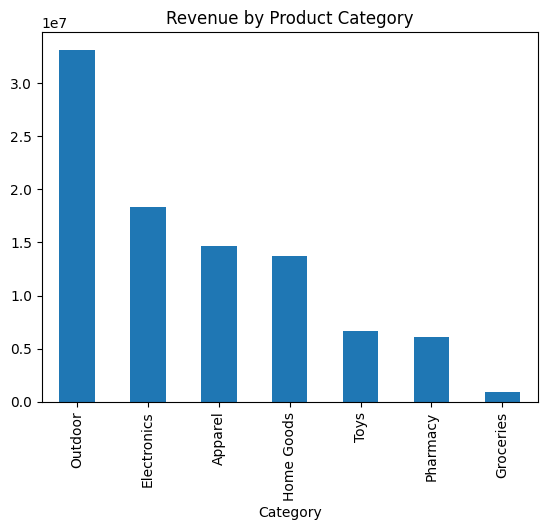

In [0]:

rev_cat = (
    df.groupBy("Category")
      .agg(F.sum("Total_Price").alias("Revenue_CAD"))
      .orderBy(F.desc("Revenue_CAD"))
)
display(rev_cat)

rev_cat.toPandas().plot(kind="bar", x="Category", y="Revenue_CAD", legend=False,
                        title="Revenue by Product Category")





<Axes: title={'center': 'Profit by Product Category'}, xlabel='Category'>

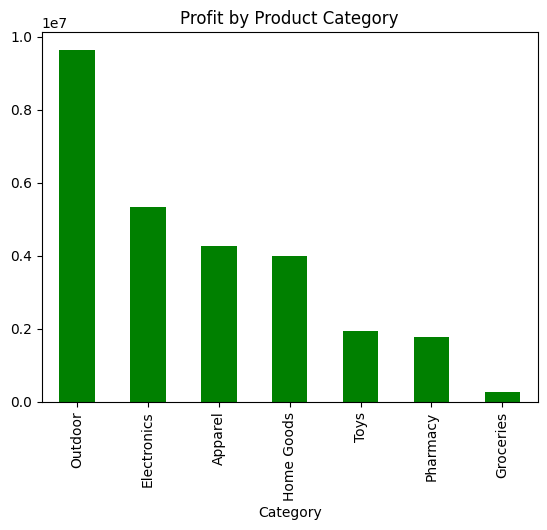

In [0]:
# Step 1: Add Profit Column (if not already done)
df = df.withColumn("Unit_Cost", F.col("Unit_Price") * 0.7)
df = df.withColumn("Profit", F.col("Total_Price") - (F.col("Unit_Cost") * F.col("Quantity")))

# Step 2: Group by Category and Sum Profit
profit_cat = (
    df.groupBy("Category")
      .agg(F.sum("Profit").alias("Profit_CAD"))
      .orderBy(F.desc("Profit_CAD"))
)

# Step 3: Plot the Profit by Category
profit_cat_pd = profit_cat.toPandas()

profit_cat_pd.plot(kind="bar", x="Category", y="Profit_CAD", legend=False,
                   title="Profit by Product Category", color="green")


Year,Category,Revenue_CAD
2020,Apparel,1477044.24999999
2020,Electronics,1872104.4899999583
2020,Groceries,93648.68000000178
2020,Home Goods,1421303.979999983
2020,Outdoor,3475740.9500000346
2020,Pharmacy,632111.7399999967
2020,Toys,682309.1100000031
2021,Apparel,2782119.5700000334
2021,Electronics,3398329.209999918
2021,Groceries,172702.14000000048


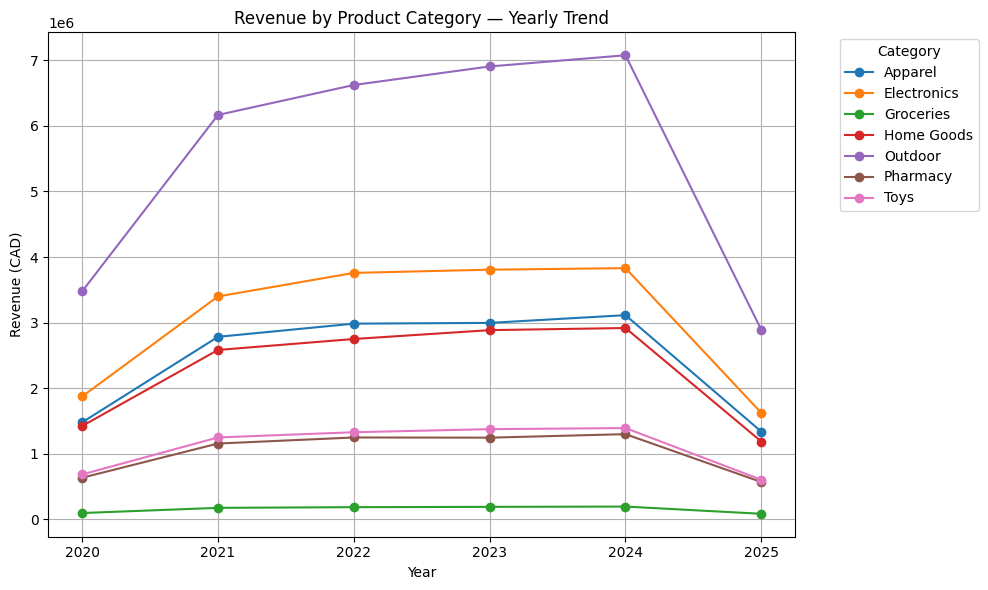

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# 1️⃣  Revenue by Category & Year
rev_cat_year = (
    df.withColumn("Year", F.year("Transaction_Timestamp"))
      .groupBy("Year", "Category")
      .agg(F.sum("Total_Price").alias("Revenue_CAD"))
      .orderBy("Year", "Category")
)

display(rev_cat_year)   # interactive table

# 2️⃣  Convert to pandas & pivot so each category is a separate line
pd_cat_year = rev_cat_year.toPandas()
pivot_cat   = pd_cat_year.pivot(index="Year", columns="Category", values="Revenue_CAD").sort_index()

# 3️⃣  Plot
pivot_cat.plot(marker="o", figsize=(10,6))
plt.title("Revenue by Product Category — Yearly Trend")
plt.xlabel("Year")
plt.ylabel("Revenue (CAD)")
plt.grid(True)
plt.legend(title="Category", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()


Category,Orders,Avg_Unit_Price
Groceries,183997,1.6727364576596448
Apparel,92640,52.08297582037932
Outdoor,69542,154.29339420780116
Electronics,69404,260.33450319868444
Pharmacy,69309,29.382115165416327
Home Goods,68898,66.34274318557551
Toys,46210,46.805970569136974


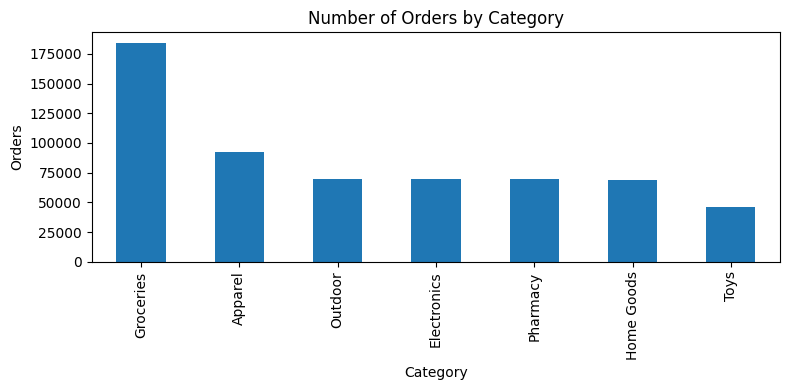

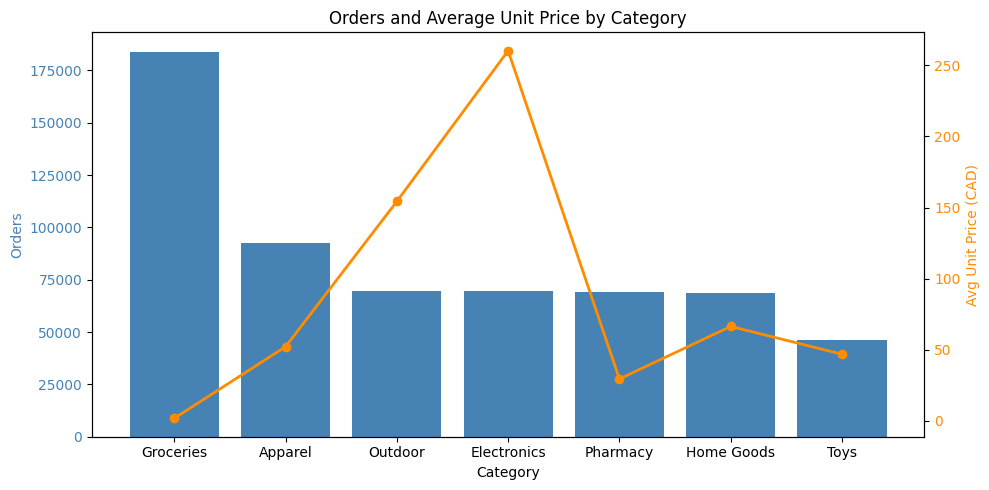

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# 1️⃣  Aggregate orders and average unit price per category
cat_stats = (
    df.groupBy("Category")
      .agg(
          F.count("*").alias("Orders"),
          F.avg("Unit_Price").alias("Avg_Unit_Price")
      )
      .orderBy(F.desc("Orders"))
)

# 2️⃣  Display the Spark table for exact numbers
display(cat_stats)

# 3️⃣  Convert to pandas for plotting
pd_stats = cat_stats.toPandas()

# ----- Plot A: Orders per category (simple bar) ----------------------------
pd_stats.plot(kind="bar", x="Category", y="Orders", legend=False,
              title="Number of Orders by Category", figsize=(8,4))
plt.ylabel("Orders")
plt.tight_layout()

# ----- Plot B: Orders (bars) + Avg Unit Price (line) on twin axes ----------
fig, ax1 = plt.subplots(figsize=(10,5))

# Bars for order count
ax1.bar(pd_stats["Category"], pd_stats["Orders"], color="steelblue")
ax1.set_ylabel("Orders", color="steelblue")
ax1.tick_params(axis='y', labelcolor="steelblue")
ax1.set_xlabel("Category")

# Line for average unit price
ax2 = ax1.twinx()
ax2.plot(pd_stats["Category"], pd_stats["Avg_Unit_Price"],
         color="darkorange", marker="o", linewidth=2)
ax2.set_ylabel("Avg Unit Price (CAD)", color="darkorange")
ax2.tick_params(axis='y', labelcolor="darkorange")

plt.title("Orders and Average Unit Price by Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Loyalty_Member,Transactions,Revenue_CAD,Avg_Revenue_per_Txn
true,253926,3.890660786000055E7,153.2202604695878
false,346074,5.46177533600042E7,157.82102486752603


<Axes: title={'center': 'Avg Basket Size – Loyalty vs\xa0Non‑Loyalty'}, xlabel='Loyalty_Member'>

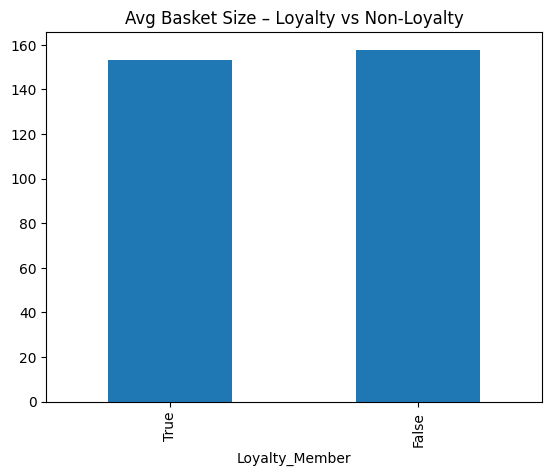

In [0]:
rev_loyal = (
    df.groupBy("Loyalty_Member")
      .agg(
          F.count("*").alias("Transactions"),
          F.sum("Total_Price").alias("Revenue_CAD"),
          F.avg("Total_Price").alias("Avg_Revenue_per_Txn")
      )
)
display(rev_loyal)

# bar plot of average basket size
rev_loyal_pd = rev_loyal.toPandas()
rev_loyal_pd.plot(kind="bar", x="Loyalty_Member", y="Avg_Revenue_per_Txn",
                  legend=False, title="Avg Basket Size – Loyalty vs Non‑Loyalty")


Customer experience

Year,count,Acquisition_Cost_CAD
2020,52220,417760.0
2021,43020,344160.0
2022,15782,126256.0
2023,5649,45192.0
2024,2076,16608.0
2025,439,3512.0


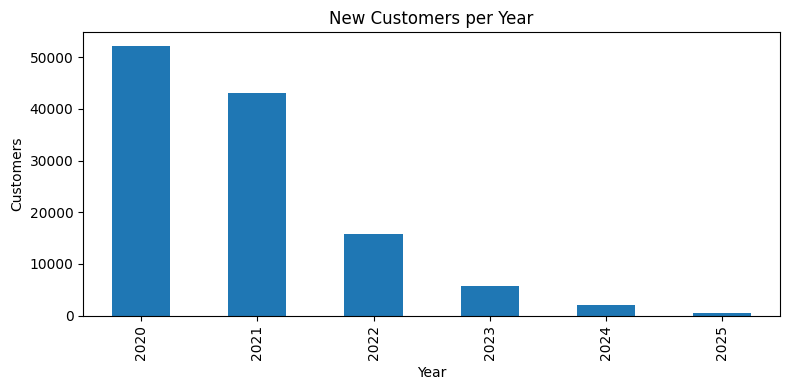

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# 1️⃣  Identify first purchase date for each customer
first_tx = (
    df.groupBy("Customer_ID")
      .agg(
          F.min("Transaction_Timestamp").alias("First_Date"),
          F.first("Store_Type").alias("Segment")      # use Store_Type
      )
)

# 2️⃣  New customers acquired per calendar year
new_per_year = (
    first_tx.groupBy(F.year("First_Date").alias("Year"))
            .count()
            .orderBy("Year")
)

# 3️⃣  Optional CAC dollars
assumed_cac = 8.0  # CAD per new customer
new_per_year = new_per_year.withColumn(
    "Acquisition_Cost_CAD", F.col("count") * assumed_cac
)

# 4️⃣  Display table
display(new_per_year)

# 5️⃣  Plot bar chart of new customers per year
pd_new = new_per_year.select("Year", "count").toPandas()
pd_new.plot(kind="bar", x="Year", y="count", legend=False,
            title="New Customers per Year", figsize=(8,4))
plt.ylabel("Customers")
plt.tight_layout()



Year,Cust_Status,count
2020,New,68491
2021,Existing,52588
2021,New,68455
2022,Existing,96418
2022,New,25166
2023,Existing,111056
2023,New,8882
2024,Existing,116359
2024,New,3253
2025,Existing,48795


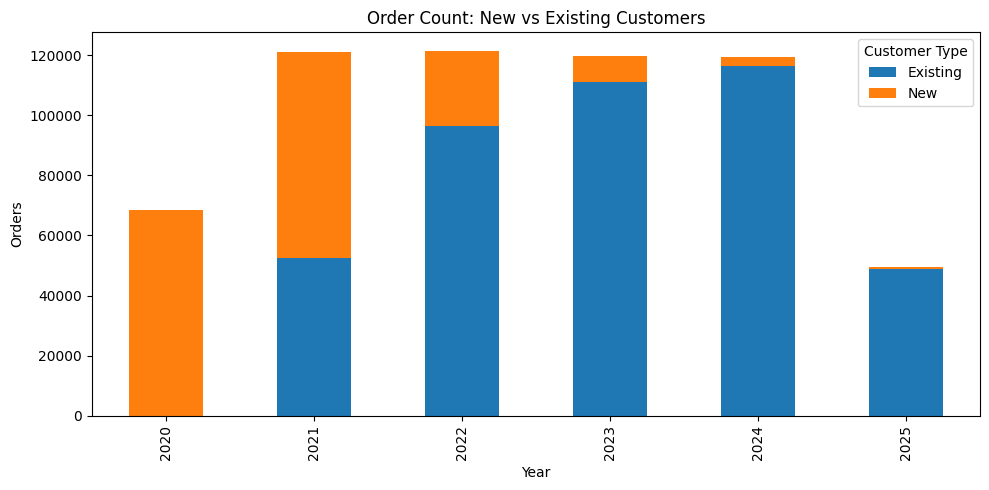

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# 1️⃣  Ensure a Year column exists
df_y = df.withColumn("Year", F.year("Transaction_Timestamp"))

# 2️⃣  Find the first‑purchase year for every customer
first_year = (
    df_y.groupBy("Customer_ID")
        .agg(F.min("Year").alias("First_Year"))
)

# 3️⃣  Label each transaction as New or Existing for its Year
df_labeled = (
    df_y.join(first_year, "Customer_ID")
        .withColumn(
            "Cust_Status",
            F.when(F.col("Year") == F.col("First_Year"), F.lit("New"))
             .otherwise(F.lit("Existing"))
        )
)

# 4️⃣  Order count by Year and Cust_Status
orders_by_seg = (
    df_labeled.groupBy("Year", "Cust_Status")
              .count()
              .orderBy("Year", "Cust_Status")
)

display(orders_by_seg)   # interactive table

# -----------------------------------------------------------
# 5️⃣  Plot stacked bar chart
pd_orders = orders_by_seg.toPandas()
pivot = pd_orders.pivot(index="Year", columns="Cust_Status", values="count").fillna(0)

pivot.plot(kind="bar", stacked=True, figsize=(10,5))
plt.title("Order Count: New vs Existing Customers")
plt.xlabel("Year")
plt.ylabel("Orders")
plt.legend(title="Customer Type")
plt.tight_layout()


Year,Repeat_Customers,Total_Customers,Repeat_Rate_%
2020,13430,52220,25.71811566449636
2021,32171,76077,42.2874193251574
2022,32144,76433,42.05513325396099
2023,31508,75938,41.49174326424188
2024,31533,75720,41.64421553090333
2025,7796,40424,19.285572926974076


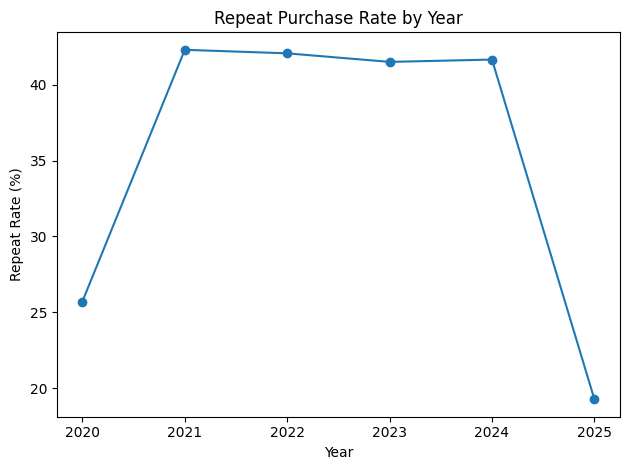

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# 🔑 1.  Attach a Year column once
df_y = df.withColumn("Year", F.year("Transaction_Timestamp"))

# 🔁 2.  Repeat‑purchase customers (≥ 2 txns in same year)
repeat = (
    df_y.groupBy("Year", "Customer_ID")
        .count()
        .where(F.col("count") >= 2)
        .groupBy("Year")
        .count()
        .withColumnRenamed("count", "Repeat_Customers")
)

# 👥 3.  Total customers per year
cust_per_year = (
    df_y.groupBy("Year")
        .agg(F.countDistinct("Customer_ID").alias("Total_Customers"))
)

# 📈 4.  Repeat‑rate %
repeat_rate = (
    repeat.join(cust_per_year, "Year")
          .withColumn("Repeat_Rate_%",
                      F.col("Repeat_Customers") / F.col("Total_Customers") * 100)
          .orderBy("Year")
)

display(repeat_rate)          # interactive table

# 5️⃣  Plot
pd_repeat = repeat_rate.toPandas()
pd_repeat.plot(x="Year", y="Repeat_Rate_%", marker="o",
               title="Repeat Purchase Rate by Year", legend=False)
plt.ylabel("Repeat Rate (%)")
plt.tight_layout()


/databricks/python/lib/python3.11/site-packages/pyspark/sql/connect/expressions.py:1017: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


Year,Retained,Base,Retention_%
2020,33057,52220,63.30333205668326
2021,48515,76077,63.770916308476934
2022,48497,76433,63.45034212970837
2023,47866,75938,63.03300060575733
2024,25378,75720,33.515583729529844


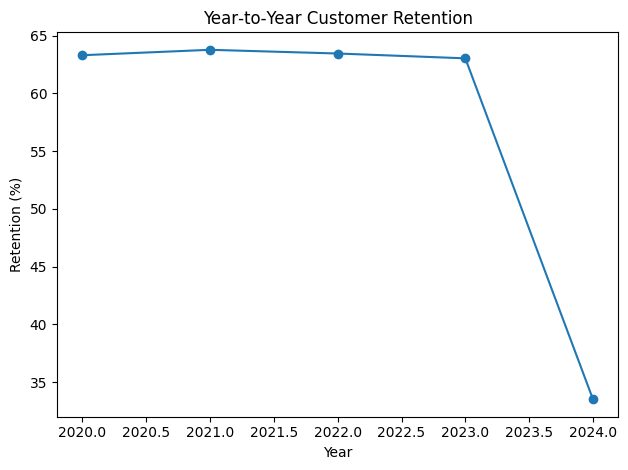

/databricks/python/lib/python3.11/site-packages/pyspark/sql/connect/expressions.py:1017: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


In [0]:
from pyspark.sql import Window, functions as F
import matplotlib.pyplot as plt

# Ensure Year column
df_y = df.withColumn("Year", F.year("Transaction_Timestamp"))

# Collect yearly customer sets
yearly_sets = (
    df_y.groupBy("Year")
        .agg(F.collect_set("Customer_ID").alias("custs"))
        .orderBy("Year")
)

# Window for lead()
w = Window.orderBy("Year")

# Retention calc
ret = (
    yearly_sets
     .withColumn("Next_custs", F.lead("custs").over(w))
     .where(F.col("Next_custs").isNotNull())
     .select("Year",
             F.size(F.array_intersect("custs", "Next_custs")).alias("Retained"),
             F.size("custs").alias("Base"))
     .withColumn("Retention_%", F.col("Retained")/F.col("Base")*100)
     .orderBy("Year")
)

display(ret)

ret.toPandas().plot(x="Year", y="Retention_%", marker="o",
                    title="Year‑to‑Year Customer Retention", legend=False)
plt.ylabel("Retention (%)")
plt.tight_layout()



Year,Avg_Tx_Per_Cust
2020,1.3115855993872079
2021,1.5910590585853805
2022,1.5907265186503212
2023,1.5794200532012959
2024,1.579661912308505
2025,1.2203641401147833


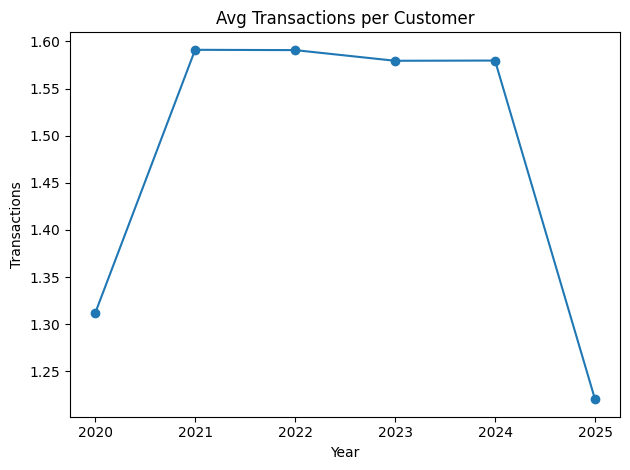

In [0]:
from pyspark.sql import Window, functions as F
import matplotlib.pyplot as plt
tx_per_cust = df_y.groupBy("Year", "Customer_ID").count()
avg_freq = tx_per_cust.groupBy("Year") \
                      .agg(F.avg("count").alias("Avg_Tx_Per_Cust")) \
                      .orderBy("Year")

display(avg_freq)

avg_freq.toPandas().plot(x="Year", y="Avg_Tx_Per_Cust", marker="o",
                         title="Avg Transactions per Customer", legend=False)
plt.ylabel("Transactions"); plt.tight_layout()


Year,Avg_Order_Value_CAD
2020,140.95666875939884
2021,144.60831539204855
2022,155.20906410383188
2023,161.73956377461894
2024,165.68384835970306
2025,167.81883118462173


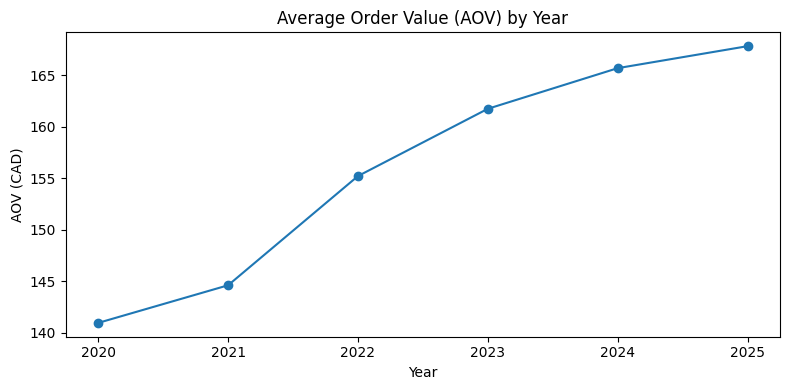

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# 1️⃣  Ensure a Year column exists
df_y = df.withColumn("Year", F.year("Transaction_Timestamp"))

# 2️⃣  Compute AOV  (mean Total_Price per transaction) per year
aov_year = (
    df_y.groupBy("Year")
        .agg(F.avg("Total_Price").alias("Avg_Order_Value_CAD"))
        .orderBy("Year")
)

# 3️⃣  Display Spark table
display(aov_year)

# 4️⃣  Plot line chart
pd_aov = aov_year.toPandas()
pd_aov.plot(x="Year", y="Avg_Order_Value_CAD", marker="o",
            title="Average Order Value (AOV) by Year", legend=False,
            figsize=(8,4))
plt.ylabel("AOV (CAD)")
plt.tight_layout()



Year,ARPC
2020,184.87673688241986
2021,230.08037015129267
2022,246.89517420485913
2023,255.45471042165875
2024,261.7244647385103
2025,204.80008361369323


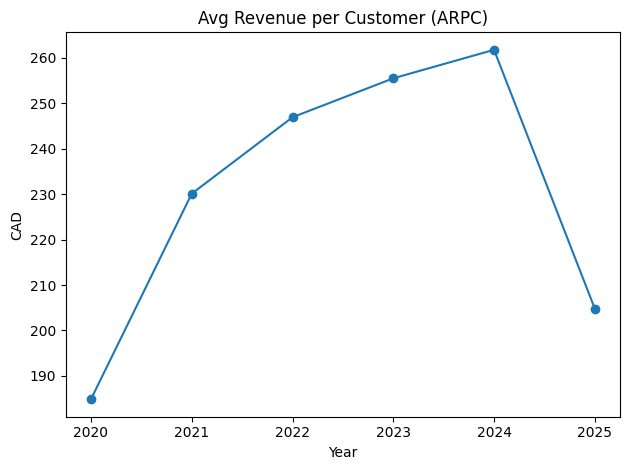

In [0]:
rev_per_cust = df_y.groupBy("Year", "Customer_ID") \
                   .agg(F.sum("Total_Price").alias("Cust_Revenue"))

arpc = rev_per_cust.groupBy("Year") \
                   .agg(F.avg("Cust_Revenue").alias("ARPC")) \
                   .orderBy("Year")

display(arpc)

arpc.toPandas().plot(x="Year", y="ARPC", marker="o",
                     title="Avg Revenue per Customer (ARPC)", legend=False)
plt.ylabel("CAD"); plt.tight_layout()


Mean_LTV,Median_LTV,Max_LTV
784.6925076770762,662.95,4932.22


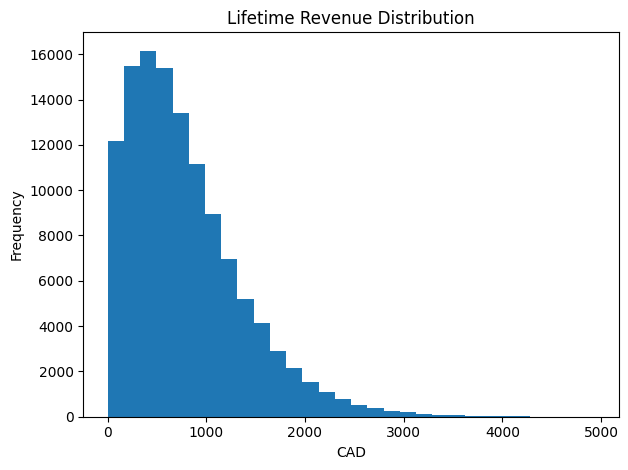

In [0]:
cust_ltv = df.groupBy("Customer_ID") \
             .agg(F.sum("Total_Price").alias("Lifetime_Revenue"))

ltv_stats = cust_ltv.select(
    F.avg("Lifetime_Revenue").alias("Mean_LTV"),
    F.expr("percentile(Lifetime_Revenue, array(0.5))")[0].alias("Median_LTV"),
    F.max("Lifetime_Revenue").alias("Max_LTV")
)

display(ltv_stats)

# Optional histogram
cust_ltv.toPandas()["Lifetime_Revenue"].plot(kind="hist", bins=30,
                                             title="Lifetime Revenue Distribution")
plt.xlabel("CAD"); plt.tight_layout()


Store_Type,count
Suburban,92553
Online,71752
Urban,25440


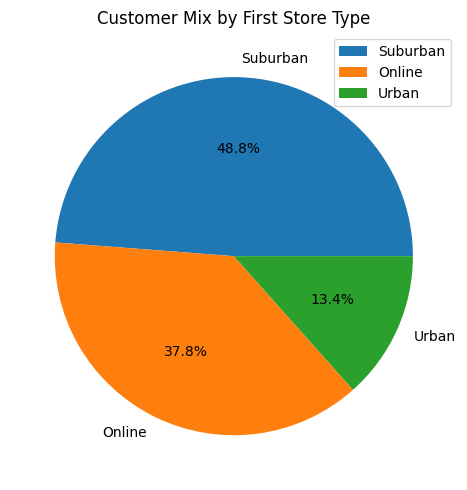

In [0]:
mix = df.select("Customer_ID", "Store_Type").distinct() \
        .groupBy("Store_Type").count()

display(mix)

mix_pd = mix.toPandas().set_index("Store_Type")
mix_pd.plot(kind="pie", y="count", autopct="%1.1f%%", figsize=(5,5),
            title="Customer Mix by First Store Type")
plt.ylabel("")
plt.tight_layout()


Year,Non_Loyal,Loyal
2020,5614198.480000038,4040064.7200000463
2021,1.0270657209999856E7,7233167.109999869
2022,1.1013702160000281E7,7857236.69000012
2023,1.1297086489999585E7,8101633.310000295
2024,1.1608671339999855E7,8209105.130000071
2025,4813437.679999822,3465400.8999999864


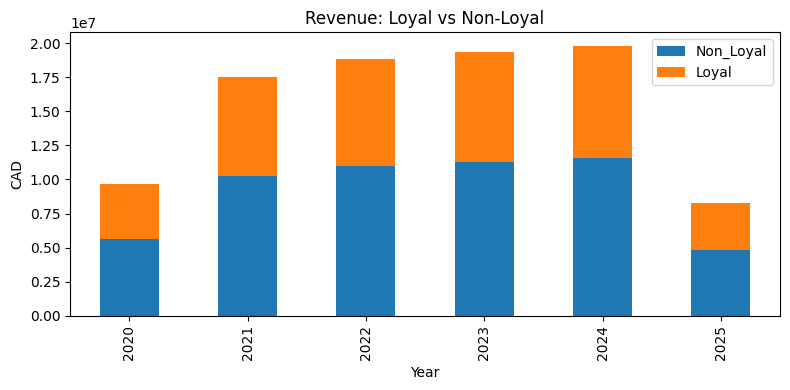

In [0]:
rev_loyal_year = (
    df_y.groupBy("Year", "Loyalty_Member")
        .agg(F.sum("Total_Price").alias("Revenue"))
        .groupBy("Year")
        .pivot("Loyalty_Member").sum("Revenue")
        .fillna(0)
        .withColumnRenamed("true",  "Loyal")
        .withColumnRenamed("false", "Non_Loyal")
        .orderBy("Year")
)

display(rev_loyal_year)

rev_loyal_year_pd = rev_loyal_year.toPandas().set_index("Year")
rev_loyal_year_pd.plot(kind="bar", stacked=True,
                       title="Revenue: Loyal vs Non‑Loyal", figsize=(8,4))
plt.ylabel("CAD"); plt.tight_layout()


Store_Type,Avg_Basket
Suburban,155.52316102843247
Online,157.07104400463456
Urban,155.90859633827588


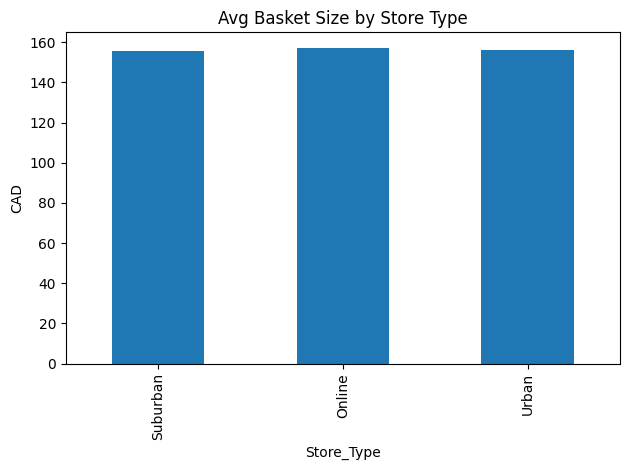

In [0]:
basket = df.groupBy("Store_Type") \
           .agg(F.avg("Total_Price").alias("Avg_Basket"))

display(basket)

basket.toPandas().plot(kind="bar", x="Store_Type", y="Avg_Basket", legend=False,
                       title="Avg Basket Size by Store Type")
plt.ylabel("CAD"); plt.tight_layout()


Income_Band,Revenue_CAD
40 k‑70 k,7.163473986000733E7
70 k‑100 k,1.362125387000012E7
Under 40 k,8219888.519999991
100 k‑130 k,48478.96999999999


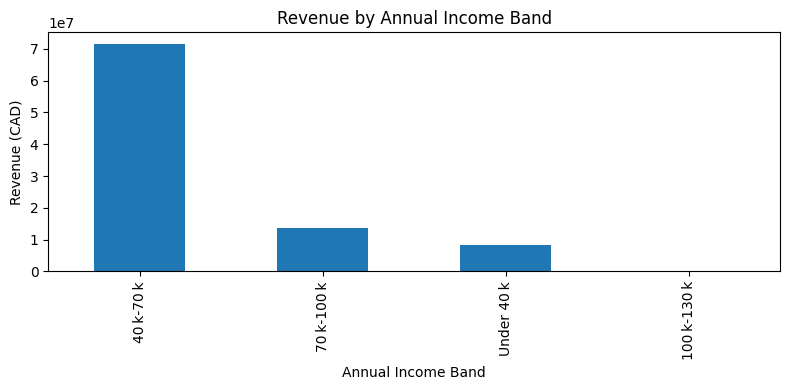

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# 1️⃣  Create income buckets
df_band = df.withColumn(
    "Income_Band",
    F.when(F.col("Annual_Income") <  40_000, "Under 40 k")
     .when(F.col("Annual_Income") <  70_000, "40 k‑70 k")
     .when(F.col("Annual_Income") < 100_000, "70 k‑100 k")
     .when(F.col("Annual_Income") < 130_000, "100 k‑130 k")
     .otherwise("130 k+")
)

# 2️⃣  Revenue by income band
rev_by_income = (
    df_band.groupBy("Income_Band")
           .agg(F.sum("Total_Price").alias("Revenue_CAD"))
           .orderBy(F.desc("Revenue_CAD"))
)

# 3️⃣  Show table in Databricks
display(rev_by_income)

# 4️⃣  Plot
pd_income = rev_by_income.toPandas()
pd_income.plot(kind="bar", x="Income_Band", y="Revenue_CAD", legend=False,
               title="Revenue by Annual Income Band", figsize=(8,4))
plt.ylabel("Revenue (CAD)")
plt.xlabel("Annual Income Band")
plt.tight_layout()


Year,Value_Segment,Revenue_CAD,Customers
2020,High,4785001.609999997,16371
2020,Low,624531.570000001,9461
2020,Mid,4244730.019999993,26388
2021,High,8711065.68,22776
2021,Low,1098270.2300000014,14551
2021,Mid,7694488.410000009,38750
2022,High,9762977.509999981,23307
2022,Low,1070230.0900000008,14202
2022,Mid,8037731.24999999,38924
2023,High,1.0173234459999999E7,23295


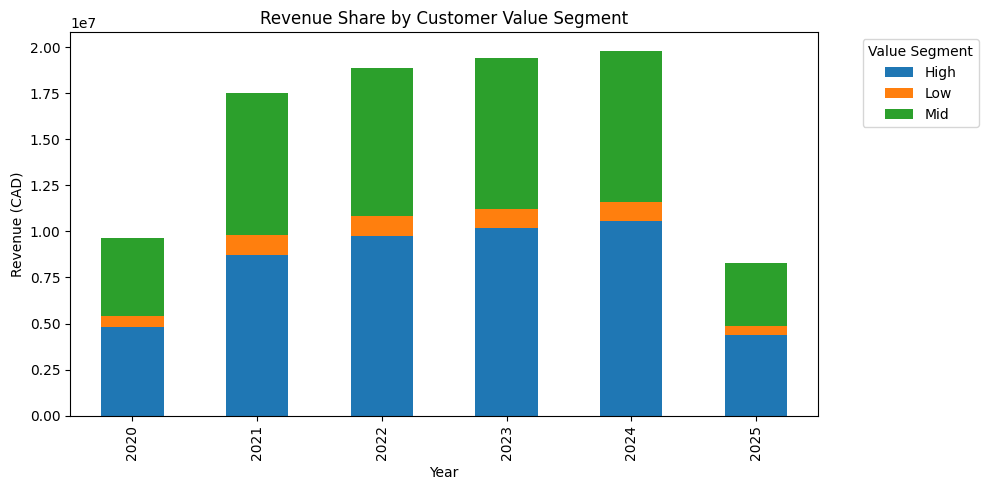

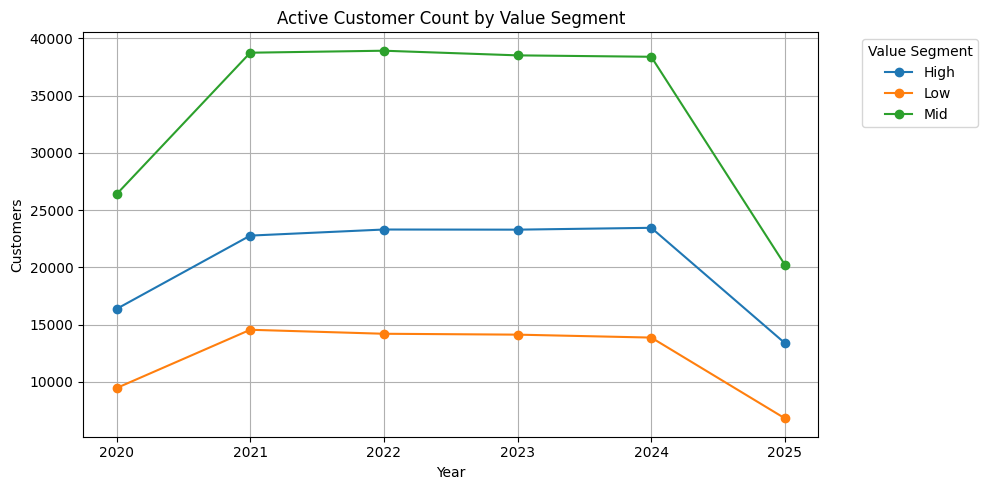

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# 1️⃣  Add Year column
df_y = df.withColumn("Year", F.year("Transaction_Timestamp"))

# 2️⃣  Lifetime revenue per customer
cust_ltv = df.groupBy("Customer_ID") \
             .agg(F.sum("Total_Price").alias("Lifetime_Revenue"))

# 3️⃣  Determine percentile thresholds (top 25%, bottom 25%)
q25, q75 = cust_ltv.approxQuantile("Lifetime_Revenue", [0.25, 0.75], 0.01)

# 4️⃣  Categorise customers: Low / Mid / High value
cust_seg = cust_ltv.withColumn(
    "Value_Segment",
    F.when(F.col("Lifetime_Revenue") <  q25, "Low")
     .when(F.col("Lifetime_Revenue") >= q75, "High")
     .otherwise("Mid")
)

# 5️⃣  Join segment info back to yearly transactions
df_seg = df_y.join(cust_seg.select("Customer_ID", "Value_Segment"), "Customer_ID")

# 6️⃣  Yearly revenue & customer count per segment
rev_seg_year = (
    df_seg.groupBy("Year", "Value_Segment")
          .agg(
              F.sum("Total_Price").alias("Revenue_CAD"),
              F.countDistinct("Customer_ID").alias("Customers")
          )
          .orderBy("Year", "Value_Segment")
)

display(rev_seg_year)   # interactive table for numbers

# 7️⃣  Pivot to pandas for plotting
pd_rev = rev_seg_year.toPandas()

# Revenue plot -------------------------------------------------
pivot_rev = pd_rev.pivot(index="Year", columns="Value_Segment", values="Revenue_CAD").fillna(0)

pivot_rev.plot(kind="bar", stacked=True, figsize=(10,5))
plt.title("Revenue Share by Customer Value Segment")
plt.xlabel("Year"); plt.ylabel("Revenue (CAD)")
plt.legend(title="Value Segment", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()

# Customer count plot -----------------------------------------
pivot_cust = pd_rev.pivot(index="Year", columns="Value_Segment", values="Customers").fillna(0)

pivot_cust.plot(marker="o", figsize=(10,5))
plt.title("Active Customer Count by Value Segment")
plt.xlabel("Year"); plt.ylabel("Customers")
plt.grid(True)
plt.legend(title="Value Segment", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()


In [0]:
last_year = df_y.groupBy("Customer_ID") \
                .agg(F.max("Year").alias("Last_Year"))

churn_counts = last_year.groupBy("Last_Year").count() \
                        .withColumnRenamed("count","Customers_Churned") \
                        .orderBy("Last_Year")

custs_by_year = df_y.groupBy("Year") \
                    .agg(F.countDistinct("Customer_ID").alias("Total_Customers"))

churn_rate = churn_counts.join(custs_by_year,
                               churn_counts.Last_Year == custs_by_year.Year) \
                         .withColumn("Churn_%",
                                     F.col("Customers_Churned")/F.col("Total_Customers")*100) \
                         .select("Last_Year","Customers_Churned","Total_Customers","Churn_%") \
                         .orderBy("Last_Year")

display(churn_rate)

churn_rate.toPandas().plot(x="Last_Year", y="Churn_%", marker="o",
                           title="Churn Rate by Cohort Last Year", legend=False)
plt.ylabel("Churn (%)"); plt.tight_layout()


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-7031296107460373>, line 1
----> 1 last_year = df_y.groupBy("Customer_ID") \
      2                 .agg(F.max("Year").alias("Last_Year"))
      4 churn_counts = last_year.groupBy("Last_Year").count() \
      5                         .withColumnRenamed("count","Customers_Churned") \
      6                         .orderBy("Last_Year")
      8 custs_by_year = df_y.groupBy("Year") \
      9                     .agg(F.countDistinct("Customer_ID").alias("Total_Customers"))

NameError: name 'df_y' is not defined

DIAGNOSTIC ANALYSIS

In [0]:
from pyspark.sql import functions as F, Window
import matplotlib.pyplot as plt

# Year column for easy grouping
df_y = df.withColumn("Year", F.year("Transaction_Timestamp"))


IsHoliday,Avg_Rev_per_Txn,Orders
1,156.8671954274975,12772
0,155.8523323138658,587228


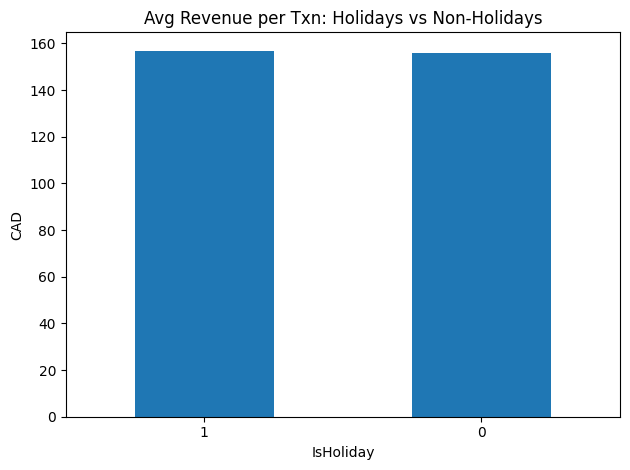

In [0]:
# Flag holiday days (add more dates if needed)
import matplotlib.pyplot as plt
holidays = ["01-01", "07-01", "12-24", "12-26", "11-11"]
df_h = df.withColumn("IsHoliday",
        F.when(F.date_format("Transaction_Timestamp","MM-dd").isin(holidays), 1).otherwise(0))

uplift = (df_h.groupBy("IsHoliday")
              .agg(F.avg("Total_Price").alias("Avg_Rev_per_Txn"),
                   F.count("*").alias("Orders")))
display(uplift)

uplift.toPandas().plot(kind="bar", x="IsHoliday", y="Avg_Rev_per_Txn",
                       legend=False, title="Avg Revenue per Txn: Holidays vs Non‑Holidays")
plt.ylabel("CAD"); plt.xticks(rotation=0); plt.tight_layout()


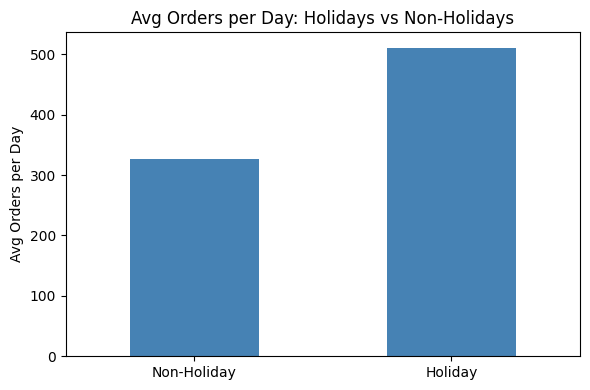

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# 1️⃣ Define holidays
holidays = ["01-01", "07-01", "11-11", "12-24", "12-26"]

# 2️⃣ Daily order counts with holiday flag
daily = (
    df.withColumn("Day", F.to_date("Transaction_Timestamp"))
      .groupBy("Day")
      .agg(F.count("*").alias("Orders"))
      .withColumn("IsHoliday", F.when(F.date_format("Day", "MM-dd").isin(holidays), 1).otherwise(0))
)

# 3️⃣ Average orders per day
avg_orders = (
    daily.groupBy("IsHoliday")
         .agg(F.avg("Orders").alias("Avg_Orders_per_Day"))
         .orderBy("IsHoliday")
)

# 4️⃣ Plot
avg_pd = avg_orders.toPandas()
ax = avg_pd.plot(kind="bar", y="Avg_Orders_per_Day", legend=False,
                 title="Avg Orders per Day: Holidays vs Non‑Holidays",
                 color=["#4682B4"], figsize=(6,4))
plt.ylabel("Avg Orders per Day")
plt.xticks(ticks=[0,1], labels=["Non‑Holiday", "Holiday"], rotation=0)
plt.tight_layout()
plt.show()




Category,Avg_Price,Avg_Qty
Outdoor,154.29339420780116,3.1317764804003336
Groceries,1.6727364576596448,3.0004837035386447
Toys,46.805970569136974,3.098571737719108
Pharmacy,29.382115165416327,3.055303063094259
Home Goods,66.34274318557551,3.052193097042004
Apparel,52.08297582037932,3.0800949913644216
Electronics,260.33450319868444,1.0249985591608552


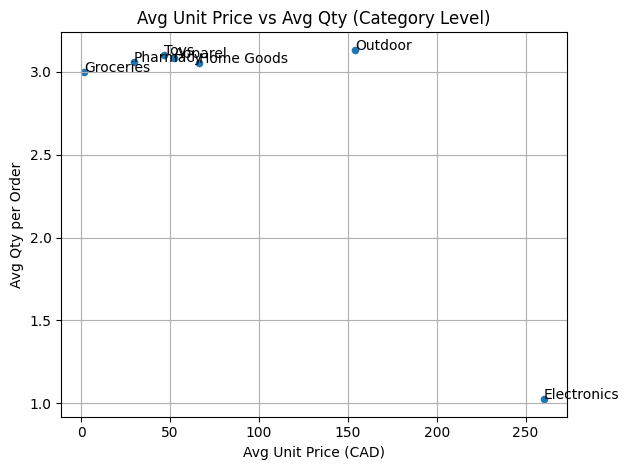

In [0]:
price_qty = (df.groupBy("Category")
               .agg(F.avg("Unit_Price").alias("Avg_Price"),
                    F.avg("Quantity").alias("Avg_Qty")))
display(price_qty)

pd_pq = price_qty.toPandas()
pd_pq.plot(kind="scatter", x="Avg_Price", y="Avg_Qty")
for _,r in pd_pq.iterrows():
    plt.text(r["Avg_Price"], r["Avg_Qty"], r["Category"])
plt.title("Avg Unit Price vs Avg Qty (Category Level)")
plt.xlabel("Avg Unit Price (CAD)"); plt.ylabel("Avg Qty per Order")
plt.grid(); plt.tight_layout()


In [0]:
pip install adjustText


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


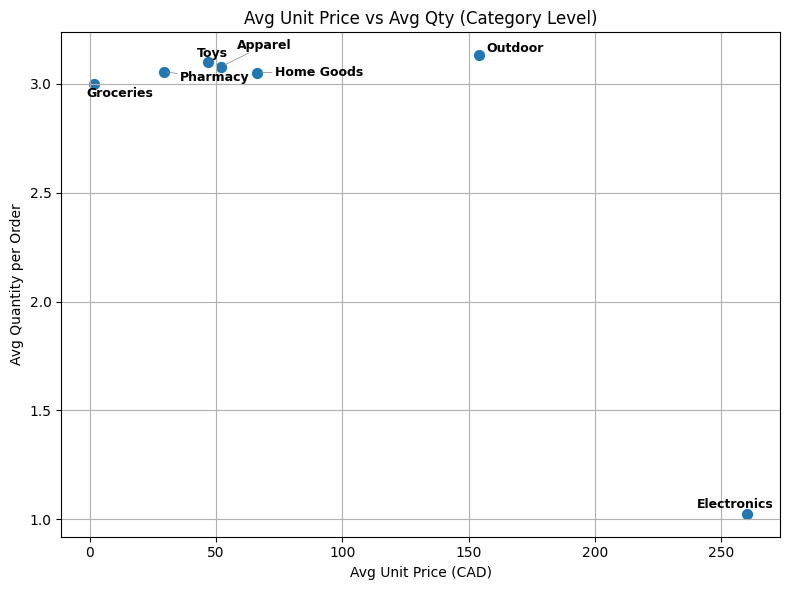

In [0]:

from pyspark.sql import functions as F
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Calculate average unit price and average quantity by category
avg_data = (
    df.groupBy("Category")
      .agg(F.avg("Unit_Price").alias("Avg_Unit_Price"),
           F.avg("Quantity").alias("Avg_Quantity"))
      .orderBy("Category")
)

# Convert to pandas
pd_avg = avg_data.toPandas()

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(pd_avg["Avg_Unit_Price"], pd_avg["Avg_Quantity"], s=50)

# Text labels
texts = []
for i in range(len(pd_avg)):
    texts.append(
        plt.text(pd_avg["Avg_Unit_Price"][i],
                 pd_avg["Avg_Quantity"][i],
                 pd_avg["Category"][i],
                 fontsize=9, weight="bold")
    )

adjust_text(texts, arrowprops=dict(arrowstyle="->", color='gray', lw=0.5))

plt.title("Avg Unit Price vs Avg Qty (Category Level)")
plt.xlabel("Avg Unit Price (CAD)")
plt.ylabel("Avg Quantity per Order")
plt.grid(True)
plt.tight_layout()
plt.show()


In [0]:
# monthly revenue series
rev_month = (df_y.groupBy(F.date_format("Transaction_Timestamp","yyyy-MM").alias("YM"))
                 .agg(F.sum("Total_Price").alias("Rev"))
                 .orderBy("YM").toPandas())

from statsmodels.tsa.seasonal import STL
stl = STL(rev_month["Rev"], period=12).fit()
stl.plot(); plt.tight_layout()


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-4666843414921984>, line 2
      1 # monthly revenue series
----> 2 rev_month = (df_y.groupBy(F.date_format("Transaction_Timestamp","yyyy-MM").alias("YM"))
      3                  .agg(F.sum("Total_Price").alias("Rev"))
      4                  .orderBy("YM").toPandas())
      6 from statsmodels.tsa.seasonal import STL
      7 stl = STL(rev_month["Rev"], period=12).fit()

NameError: name 'df_y' is not defined

/databricks/python/lib/python3.11/site-packages/pyspark/sql/connect/expressions.py:1017: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


Year,Transactions,Revenue,AOV,Tx_YoY_%,AOV_YoY_%
2020,68491,9654263.199999986,140.95666875939884,null,null
2021,121043,1.7503824319999732E7,144.60831539204855,76.72832926953906,2.5906164389304407
2022,121584,1.8870938850000296E7,155.20906410383188,0.4469486050411837,7.330663304557255
2023,119938,1.9398719800000247E7,161.73956377461894,-1.353796552177918,4.2075504471944285
2024,119612,1.9817776470000803E7,165.68384835970306,-0.2718071003351732,2.438664043004596
2025,49332,8278838.57999976,167.81883118462173,-58.7566464903187,1.2885883844776311


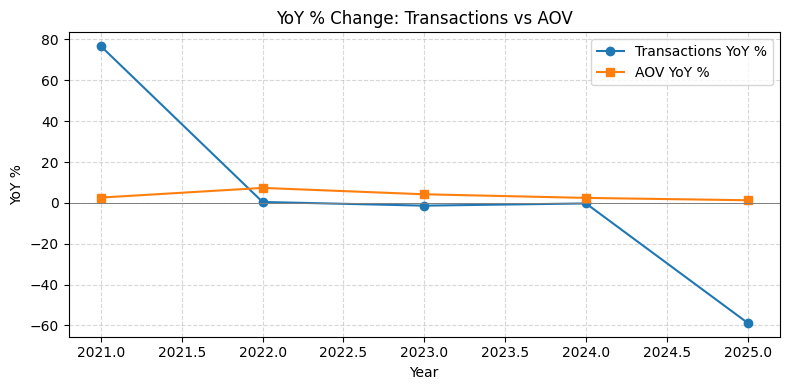

/databricks/python/lib/python3.11/site-packages/pyspark/sql/connect/expressions.py:1017: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(
/databricks/python/lib/python3.11/site-packages/pyspark/sql/connect/expressions.py:1017: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


In [0]:
from pyspark.sql import functions as F, Window
import matplotlib.pyplot as plt

# 1️⃣  Add Year column once
df_y = df.withColumn("Year", F.year("Transaction_Timestamp"))

# 2️⃣  Annual KPIs: Transactions, Revenue, AOV
kpi = (
    df_y.groupBy("Year")
        .agg(
            F.count("*").alias("Transactions"),
            F.sum("Total_Price").alias("Revenue"),
            F.avg("Total_Price").alias("AOV")
        )
        .orderBy("Year")
)

# 3️⃣  Compute YoY % for Transactions and AOV
w = Window.orderBy("Year")
kpi_yoy = (
    kpi.withColumn("Tx_YoY_%",
                   (F.col("Transactions") - F.lag("Transactions").over(w))
                   / F.lag("Transactions").over(w) * 100)
        .withColumn("AOV_YoY_%",
                   (F.col("AOV") - F.lag("AOV").over(w))
                   / F.lag("AOV").over(w) * 100)
)

display(kpi_yoy)   # interactive Spark table

# 4️⃣  Plot YoY % lines
pd_kpi = kpi_yoy.toPandas()
pd_kpi.plot(x="Year", y="Tx_YoY_%", marker="o", label="Transactions YoY %",
            figsize=(8,4))
pd_kpi.plot(x="Year", y="AOV_YoY_%", marker="s", label="AOV YoY %",
            ax=plt.gca())
plt.axhline(0, color="gray", linewidth=0.7)
plt.title("YoY % Change: Transactions vs AOV")
plt.ylabel("YoY %")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


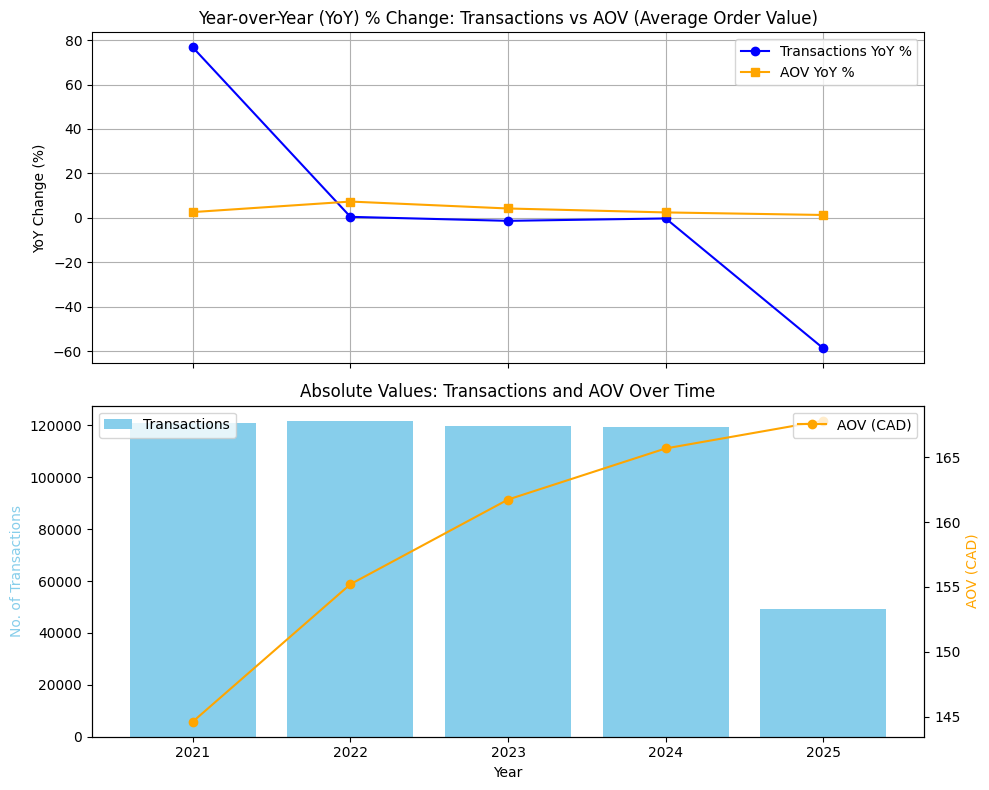

In [0]:
import matplotlib.pyplot as plt

# 📌 Actual data from your message
years = [2021, 2022, 2023, 2024, 2025]
transactions_yoy = [76.73, 0.45, -1.35, -0.27, -58.76]  # Rounded for clarity
aov_yoy = [2.59, 7.33, 4.21, 2.44, 1.29]
transactions = [121043, 121584, 119938, 119612, 49332]
aov_values = [144.61, 155.21, 161.74, 165.68, 167.82]

# 🔲 Setup
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# -------------------------------
# 🔷 Top: YoY % Change Chart
# -------------------------------
ax1.plot(years, transactions_yoy, marker='o', label='Transactions YoY %', color='blue')
ax1.plot(years, aov_yoy, marker='s', label='AOV YoY %', color='orange')
ax1.set_ylabel("YoY Change (%)")
ax1.set_title("Year-over-Year (YoY) % Change: Transactions vs AOV (Average Order Value)")
ax1.legend()
ax1.grid(True)

# -------------------------------
# 🔶 Bottom: Absolute Values Chart
# -------------------------------
ax2.bar(years, transactions, label='Transactions', color='skyblue')
ax2.set_ylabel("No. of Transactions", color='skyblue')

# Twin axis for AOV line
ax3 = ax2.twinx()
ax3.plot(years, aov_values, label='AOV (CAD)', color='orange', marker='o')
ax3.set_ylabel("AOV (CAD)", color='orange')

# Final touches
ax2.set_title("Absolute Values: Transactions and AOV Over Time")
ax2.set_xlabel("Year")
ax2.legend(loc='upper left')
ax3.legend(loc='upper right')
plt.tight_layout()
plt.show()



In [0]:
from pyspark.sql import functions as F
import calendar

# -------------------------------------------------
# 1️⃣  Add Year and Day columns
df_y = (
    df.withColumn("Year", F.year("Transaction_Timestamp"))
      .withColumn("Day",  F.to_date("Transaction_Timestamp"))
)

# -------------------------------------------------
# 2️⃣  For each year: total txns, revenue, days observed
yearly_raw = (
    df_y.groupBy("Year")
        .agg(
            F.count("*").alias("Transactions"),
            F.sum("Total_Price").alias("Revenue_CAD"),
            F.countDistinct("Day").alias("Days_Observed")
        )
        .orderBy("Year")
)

# -------------------------------------------------
# 3️⃣  Compute days in calendar year (365/366) & annualise
yearly = (
    yearly_raw.withColumn(
        "Days_in_Year",
        F.expr("CASE WHEN mod(Year,400)=0 OR (mod(Year,4)=0 AND mod(Year,100)<>0) THEN 366 ELSE 365 END")
    )
    .withColumn("Annual_Factor", F.col("Days_in_Year") / F.col("Days_Observed"))
    .withColumn("Annualised_Transactions", (F.col("Transactions") * F.col("Annual_Factor")).cast("bigint"))
    .withColumn("Annualised_Revenue_CAD",   F.col("Revenue_CAD") * F.col("Annual_Factor"))
    .withColumn("AOV", F.col("Revenue_CAD") / F.col("Transactions"))
    .withColumn("Annualised_AOV", F.col("Annualised_Revenue_CAD") / F.col("Annualised_Transactions"))
    .select(
        "Year", "Transactions", "Revenue_CAD", "AOV",
        "Days_Observed", "Days_in_Year", "Annual_Factor",
        "Annualised_Transactions", "Annualised_Revenue_CAD", "Annualised_AOV"
    )
)

display(yearly)


Year,Transactions,Revenue_CAD,AOV,Days_Observed,Days_in_Year,Annual_Factor,Annualised_Transactions,Annualised_Revenue_CAD,Annualised_AOV
2020,68491,9654263.199999997,140.956668759399,214,366,1.7102803738317758,117138,1.6511496874766352E7,140.9576471748395
2021,121043,1.7503824319999993E7,144.6083153920507,365,365,1.0,121043,1.7503824319999993E7,144.6083153920507
2022,121584,1.8870938850000013E7,155.20906410382955,365,365,1.0,121584,1.8870938850000013E7,155.20906410382955
2023,119938,1.9398719800000004E7,161.73956377461693,365,365,1.0,119938,1.9398719800000004E7,161.73956377461693
2024,119612,1.981777647000001E7,165.68384835969644,366,366,1.0,119612,1.981777647000001E7,165.68384835969644
2025,49332,8278838.579999999,167.8188311846266,151,365,2.4172185430463577,119246,2.0011762130463574E7,167.81914806755424


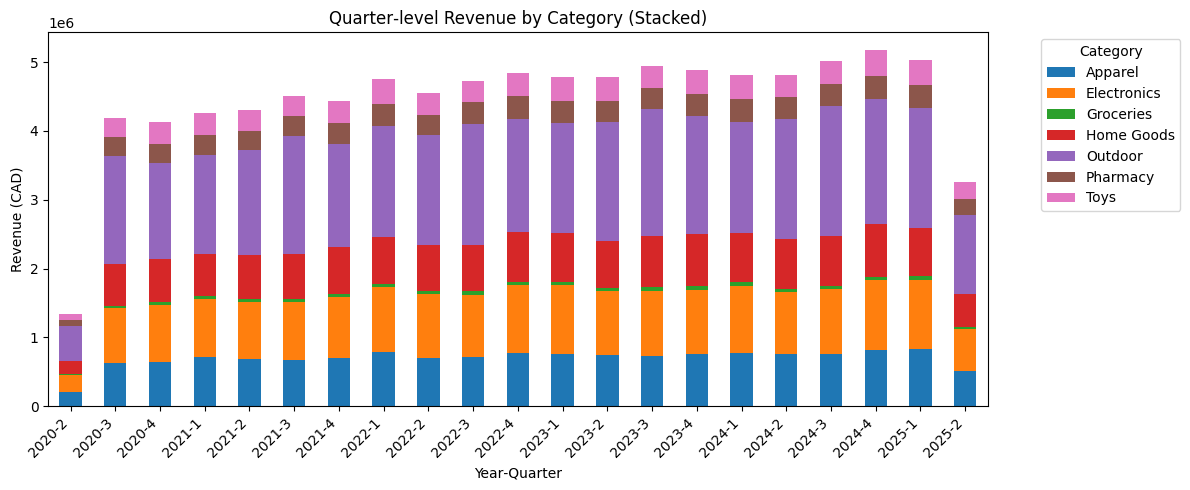

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# 1️⃣  Add Year & Quarter columns
df_q = (df.withColumn("Year", F.year("Transaction_Timestamp"))
          .withColumn("Quarter", F.quarter("Transaction_Timestamp"))
          .withColumn("Year_Q", F.concat_ws("‑", F.col("Year"), F.col("Quarter"))))

# 2️⃣  Aggregate revenue by Year‑Quarter & Category
rev_q_cat = (df_q.groupBy("Year_Q", "Quarter", "Category")
                 .agg(F.sum("Total_Price").alias("Revenue_CAD"))
                 .orderBy("Year_Q", "Category"))

# 3️⃣  Pivot so each category becomes a column for stacked bar
pd_rev = rev_q_cat.toPandas()
pivot = pd_rev.pivot(index="Year_Q", columns="Category", values="Revenue_CAD").fillna(0)

# 4️⃣  Plot stacked bar chart
pivot.plot(kind="bar", stacked=True, figsize=(12,5))
plt.title("Quarter‑level Revenue by Category (Stacked)")
plt.xlabel("Year‑Quarter")
plt.ylabel("Revenue (CAD)")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Category", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()


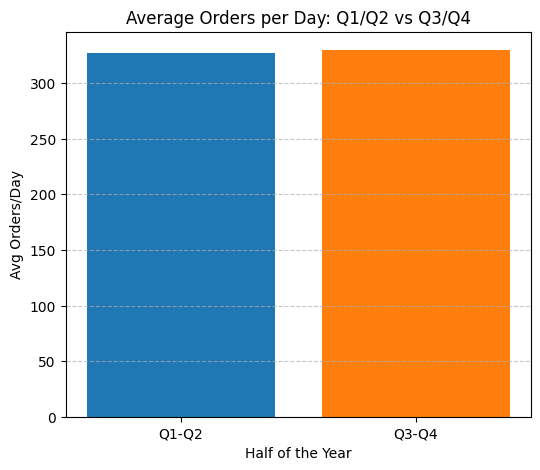

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Step 1: Extract Year, Quarter, and Date
df_with_quarter = df.withColumn("Year", F.year("Transaction_Timestamp")) \
                    .withColumn("Quarter", F.quarter("Transaction_Timestamp")) \
                    .withColumn("Date", F.to_date("Transaction_Timestamp"))

# Step 2: Group by Date to count number of orders per day
daily_orders = df_with_quarter.groupBy("Date", "Quarter") \
                              .agg(F.count("*").alias("Order_Count"))

# Step 3: Calculate average orders per day for Q1/Q2 and Q3/Q4
order_summary = (
    daily_orders.withColumn("Half", 
        F.when(F.col("Quarter").isin(1, 2), "Q1-Q2")
         .when(F.col("Quarter").isin(3, 4), "Q3-Q4"))
    .groupBy("Half")
    .agg(F.avg("Order_Count").alias("Avg_Orders_per_Day"))
    .toPandas()
)

# Step 4: Plot
plt.figure(figsize=(6, 5))
plt.bar(order_summary["Half"], order_summary["Avg_Orders_per_Day"], color=["#1f77b4", "#ff7f0e"])
plt.title("Average Orders per Day: Q1/Q2 vs Q3/Q4")
plt.ylabel("Avg Orders/Day")
plt.xlabel("Half of the Year")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


YearQ,Quarter,AOV
2020-2,2,143.3078902998605
2020-3,3,142.16551520499715
2020-4,4,139.01268613434073
2021-1,1,142.56817798029806
2021-2,2,144.0890287263946
2021-3,3,147.82684932405687
2021-4,4,143.90536771140358
2022-1,1,158.09214756389704
2022-2,2,152.05657207718554
2022-3,3,155.82459467484793


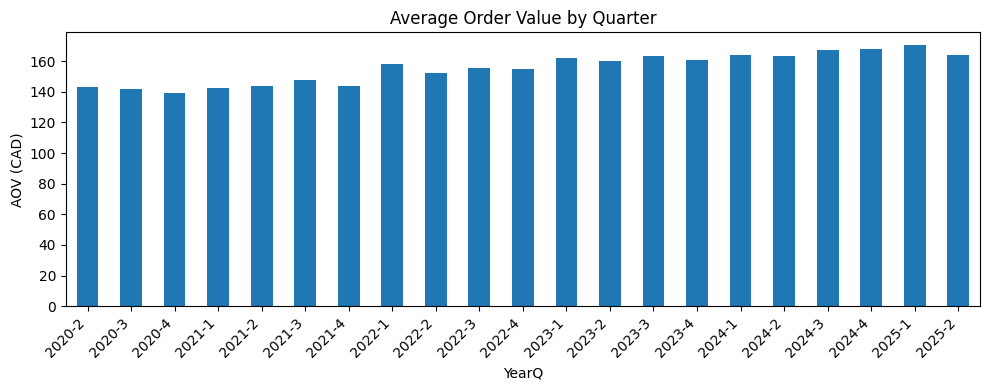

In [0]:
# Quarter-level AOV
aov_qtr = (
    df.withColumn("YearQ", F.concat_ws("-", F.year("Transaction_Timestamp"), F.quarter("Transaction_Timestamp")))
      .groupBy("YearQ", F.quarter("Transaction_Timestamp").alias("Quarter"))
      .agg(F.avg("Total_Price").alias("AOV"))
      .orderBy("YearQ")
)

display(aov_qtr)

# Plot
pd_aov = aov_qtr.toPandas()
pd_aov.plot(kind="bar", x="YearQ", y="AOV", figsize=(10,4), legend=False)
plt.title("Average Order Value by Quarter")
plt.ylabel("AOV (CAD)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


IsJuly,Category,Revenue_CAD,Total,Share_%
false,Outdoor,2.998320388999971E7,8.539033940000919E7,35.11311010200352
false,Electronics,1.677783945000089E7,8.539033940000919E7,19.64840468826979
false,Apparel,1.3460130550000168E7,8.539033940000919E7,15.763060136049441
false,Home Goods,1.2617700590000004E7,8.539033940000919E7,14.77649659043122
false,Toys,6087946.779999862,8.539033940000919E7,7.129549809470845
false,Pharmacy,5629042.069999894,8.539033940000919E7,6.592129870371834
false,Groceries,834476.070000024,8.539033940000919E7,0.9772488033932494
true,Outdoor,3158529.540000004,8134021.820000045,38.831092538180414
true,Electronics,1508887.9799999902,8134021.820000045,18.550331107914115
true,Apparel,1225494.8499999968,8134021.820000045,15.066284270183946


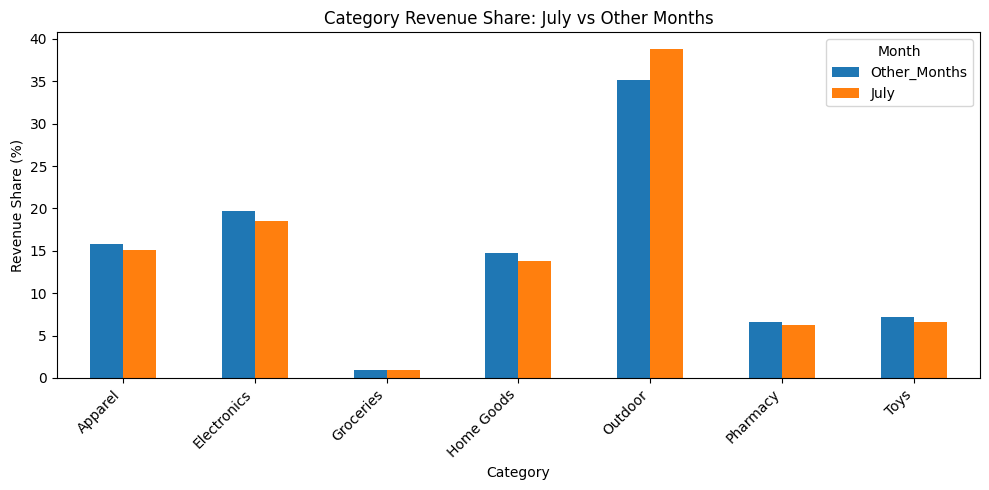

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# 1️⃣  Flag July transactions
df_july = df.withColumn("IsJuly", F.month("Transaction_Timestamp") == 7)

# 2️⃣  Revenue by category in July vs. Rest
rev_july_vs_rest = (
    df_july.groupBy("IsJuly", "Category")
           .agg(F.sum("Total_Price").alias("Revenue_CAD"))
)

# 3️⃣  Calculate revenue share within each bucket
total = rev_july_vs_rest.groupBy("IsJuly").agg(F.sum("Revenue_CAD").alias("Total"))
share = rev_july_vs_rest.join(total, "IsJuly") \
        .withColumn("Share_%", F.col("Revenue_CAD") / F.col("Total") * 100)

display(share.orderBy("IsJuly", F.desc("Share_%")))   # interactive table

# 4️⃣  Pivot for easy plotting
pd_share = share.select("IsJuly","Category","Share_%").toPandas()
pivot = pd_share.pivot(index="Category", columns="IsJuly", values="Share_%").fillna(0)
pivot.columns = ["Other_Months", "July"]  # 0=False, 1=True

# 5️⃣  Plot side-by-side bars for each category
ax = pivot.plot(kind="bar", figsize=(10,5))
plt.title("Category Revenue Share: July vs Other Months")
plt.ylabel("Revenue Share (%)")
plt.xlabel("Category")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Month")
plt.tight_layout()
plt.show()


Year,New_Customers,Marketing_Spend_CAD,CAC_CAD
2020,52220,1000000,19.149751053236308
2021,43020,1400000,32.543003254300324
2022,15782,1550000,98.2131542263338
2023,5649,1700000,300.93821915383256
2024,2076,1800000,867.0520231213873
2025,439,650000,1480.637813211845


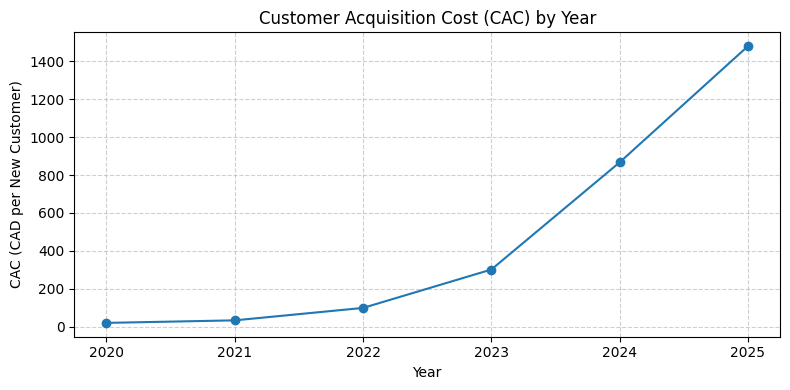

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# ---------------------------
# 1️⃣  First-purchase year per customer
first_tx = (
    df.groupBy("Customer_ID")
      .agg(F.min("Transaction_Timestamp").alias("First_Date"))
      .withColumn("Year", F.year("First_Date"))
)

new_per_year = (
    first_tx.groupBy("Year")
            .count()
            .withColumnRenamed("count", "New_Customers")
            .orderBy("Year")
)

# ---------------------------
# 2️⃣  Annual marketing spend (placeholder values, CAD)
marketing_spend = {
    2020: 1_000_000,
    2021: 1_400_000,
    2022: 1_550_000,
    2023: 1_700_000,
    2024: 1_800_000,
    2025: 650_000   # Jan–May only; adjust if you annualise
}

spend_df = spark.createDataFrame([(yr, amt) for yr, amt in marketing_spend.items()],
                                 ["Year", "Marketing_Spend_CAD"])

# ---------------------------
# 3️⃣  Join spend with new-customer counts and compute CAC
cac = (
    new_per_year.join(spend_df, "Year")
                .withColumn("CAC_CAD", F.col("Marketing_Spend_CAD") / F.col("New_Customers"))
                .orderBy("Year")
)

display(cac)

# ---------------------------
# 4️⃣  Plot CAC over time
pd_cac = cac.toPandas()
pd_cac.plot(x="Year", y="CAC_CAD", marker="o", figsize=(8,4), legend=False)
plt.title("Customer Acquisition Cost (CAC) by Year")
plt.ylabel("CAC (CAD per New Customer)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


Year,Value_Segment,Retained,Base,Retention_%
2020,Mid,16665,26388,63.15370623010459
2021,Mid,24798,38750,63.99483870967742
2022,Mid,24618,38924,63.246326174082824
2023,Mid,24143,38518,62.67978607404331
2024,Mid,12465,38395,32.46516473499154
2020,High,11929,16371,72.86665444994198
2021,High,17066,22776,74.92975061468212
2022,High,17452,23307,74.87879177929378
2023,High,17537,23295,75.28224940974458
2024,High,9917,23456,42.27916098226466


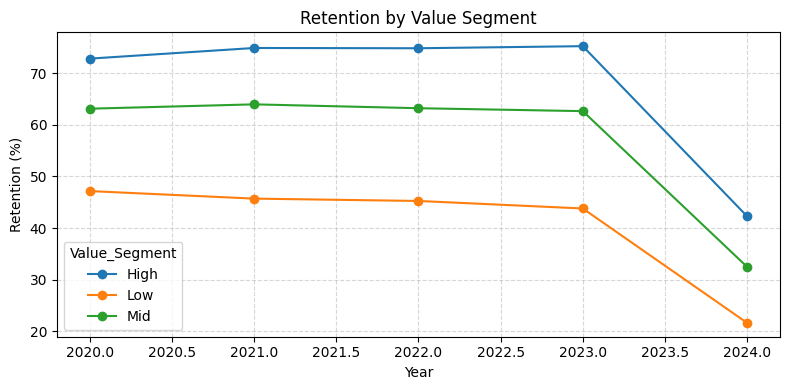

In [0]:
from pyspark.sql import functions as F, Window
import matplotlib.pyplot as plt
df_y = df.withColumn("Year", F.year("Transaction_Timestamp"))  # add Year col
# a) Lifetime revenue per customer
cust_ltv = df.groupBy("Customer_ID").agg(F.sum("Total_Price").alias("LTV"))

# b) Split into Low / Mid / High buckets (25-50-25)
q25, q75 = cust_ltv.approxQuantile("LTV", [0.25, 0.75], 0.01)
cust_seg = cust_ltv.withColumn(
    "Value_Segment",
    F.when(F.col("LTV") <  q25, "Low")
     .when(F.col("LTV") >= q75, "High")
     .otherwise("Mid")
)

# c) Yearly customer sets + segment
yearly_sets = (df_y.join(cust_seg, "Customer_ID")
                 .groupBy("Year", "Value_Segment")
                 .agg(F.collect_set("Customer_ID").alias("custs"))
                 .orderBy("Year"))

# d) Retention to next year within each segment
w = Window.partitionBy("Value_Segment").orderBy("Year")
ret = (yearly_sets
       .withColumn("Next", F.lead("custs").over(w))
       .where(F.col("Next").isNotNull())
       .select("Year","Value_Segment",
               F.size(F.array_intersect("custs","Next")).alias("Retained"),
               F.size("custs").alias("Base"))
       .withColumn("Retention_%", F.col("Retained")/F.col("Base")*100))

display(ret)

# e) Plot
pd_ret = ret.toPandas()
pivot = pd_ret.pivot(index="Year", columns="Value_Segment", values="Retention_%")
pivot.plot(marker="o", figsize=(8,4))
plt.title("Retention by Value Segment")
plt.ylabel("Retention (%)"); plt.grid(True, ls="--", alpha=.5)
plt.tight_layout()


Year,Avg_Items_Per_Basket,Avg_Unit_Price
2020,2.8158882188900733,64.11862040268137
2021,2.8284328709632116,65.80881851904105
2022,2.814654888801158,71.21202584221666
2023,2.8162634027580915,73.9109764211446
2024,2.8190398956626423,75.47126701333944
2025,2.8211708424552016,76.89961100299244


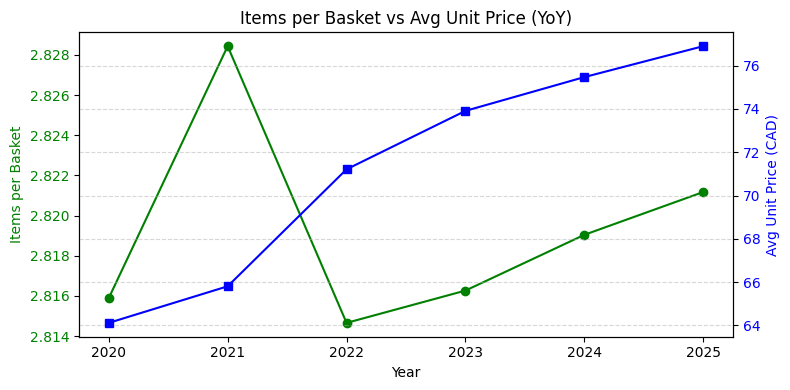

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# 1. Add Year column
df_y = df.withColumn("Year", F.year("Transaction_Timestamp"))

# 2. Items per basket (Quantity per transaction)
items = df_y.groupBy("Year", "Transaction_ID").agg(F.sum("Quantity").alias("Items"))
items_avg = items.groupBy("Year").agg(F.avg("Items").alias("Avg_Items_Per_Basket"))

# 3. Avg Unit Price per year
price_avg = df_y.groupBy("Year").agg(F.avg("Unit_Price").alias("Avg_Unit_Price"))

# 4. Merge
basket_price = items_avg.join(price_avg, "Year").orderBy("Year")

display(basket_price)

# 5. Plot
pd_bp = basket_price.toPandas()
fig, ax1 = plt.subplots(figsize=(8,4))

# Plot Avg Items per Basket (left y-axis)
ax1.plot(pd_bp["Year"], pd_bp["Avg_Items_Per_Basket"], color="green", marker="o", label="Items per Basket")
ax1.set_ylabel("Items per Basket", color="green")
ax1.tick_params(axis="y", labelcolor="green")

# Twin axis for Avg Unit Price
ax2 = ax1.twinx()
ax2.plot(pd_bp["Year"], pd_bp["Avg_Unit_Price"], color="blue", marker="s", label="Unit Price")
ax2.set_ylabel("Avg Unit Price (CAD)", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# Labels
plt.title("Items per Basket vs Avg Unit Price (YoY)")
ax1.set_xlabel("Year")
fig.tight_layout()
plt.grid(True, ls="--", alpha=0.5)
plt.show()


Store_Type,Category,Transactions
Online,Apparel,16884
Online,Electronics,12684
Online,Groceries,33690
Online,Home Goods,12609
Online,Outdoor,12754
Online,Pharmacy,12569
Online,Toys,8503
Suburban,Apparel,59264
Suburban,Electronics,44432
Suburban,Groceries,118121


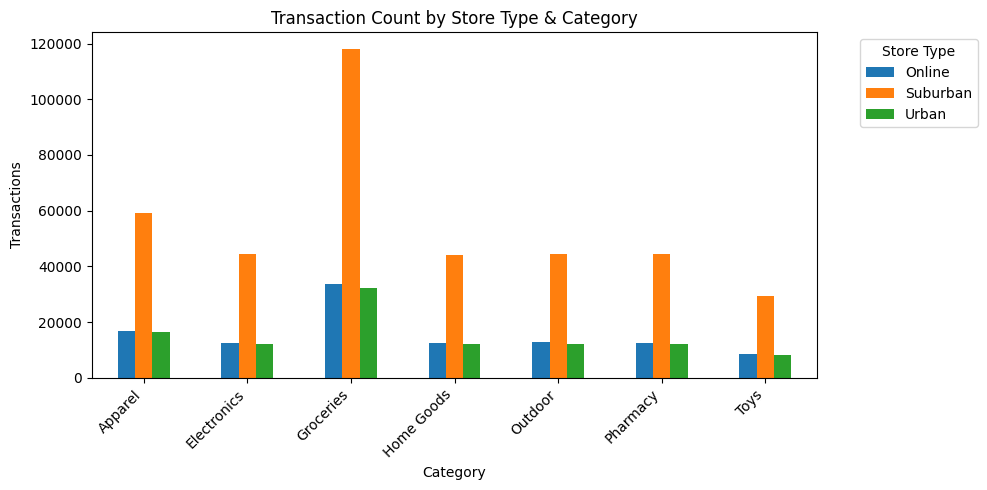

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
# 1. Aggregate transaction counts
tx_store_cat = (
    df.groupBy("Store_Type", "Category")
      .agg(F.count("*").alias("Transactions"))
      .orderBy("Store_Type", "Category")
)

display(tx_store_cat)   # interactive Spark table

# 2. Pivot to pandas for a grouped bar chart
pd_tc = tx_store_cat.toPandas()
pivot_tc = pd_tc.pivot(index="Category", columns="Store_Type", values="Transactions").fillna(0)

# 3. Plot
pivot_tc.plot(kind="bar", figsize=(10,5))
plt.title("Transaction Count by Store Type & Category")
plt.ylabel("Transactions")
plt.xlabel("Category")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Store Type", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()


Province,Transactions,Pop_2024_M,Tx_per_Capita
NT,935,0.045,0.02077777777778
NL,8487,0.500,0.01697400000000
NS,15805,1.000,0.01580500000000
MB,21728,1.400,0.01552000000000
QC,136793,8.900,0.01537000000000
NB,12259,0.800,0.01532375000000
SK,18289,1.200,0.01524083333333
ON,232222,15.600,0.01488602564103
AB,68861,4.700,0.01465127659574
BC,81519,5.600,0.01455696428571


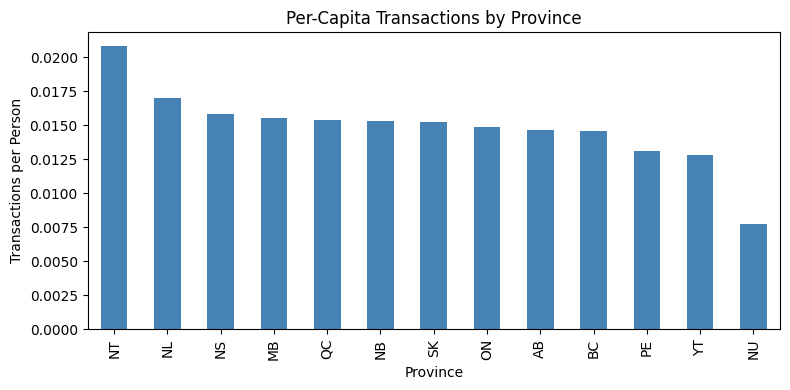

In [0]:
import pandas as pd
# 1. Static 2024 population estimates
POP = {"ON":15.6,"QC":8.9,"BC":5.6,"AB":4.7,"MB":1.4,"SK":1.2,
       "NS":1.0,"NB":0.8,"NL":0.5,"PE":0.17,"NT":0.045,"YT":0.044,"NU":0.04}

# 2. Transactions per province
tx_prov = (df.groupBy("Province")
             .agg(F.count("*").alias("Transactions"))
             .withColumn("Pop_2024_M", F.expr("CASE " + " ".join(
                 [f"WHEN Province='{k}' THEN {v}" for k,v in POP.items()]) + " END"))
             .withColumn("Tx_per_Capita", F.col("Transactions") / (F.col("Pop_2024_M") * 1_000_000))
             .orderBy(F.desc("Tx_per_Capita")))

display(tx_prov)  # Spark table

# 3. Plot with type fix
pd_pc = tx_prov.toPandas()

# ensure Tx_per_Capita is numeric
pd_pc["Tx_per_Capita"] = pd.to_numeric(pd_pc["Tx_per_Capita"], errors="coerce")

pd_pc.plot(kind="bar", x="Province", y="Tx_per_Capita", legend=False,
           title="Per-Capita Transactions by Province", figsize=(8,4), color="#4682B4")
plt.ylabel("Transactions per Person")
plt.tight_layout()
plt.show()



Year,Store_Type,Orders
2020,Online,8166
2020,Suburban,47317
2020,Urban,13008
2021,Online,18166
2021,Suburban,80693
2021,Urban,22184
2022,Online,20657
2022,Suburban,79077
2022,Urban,21850
2023,Online,24134


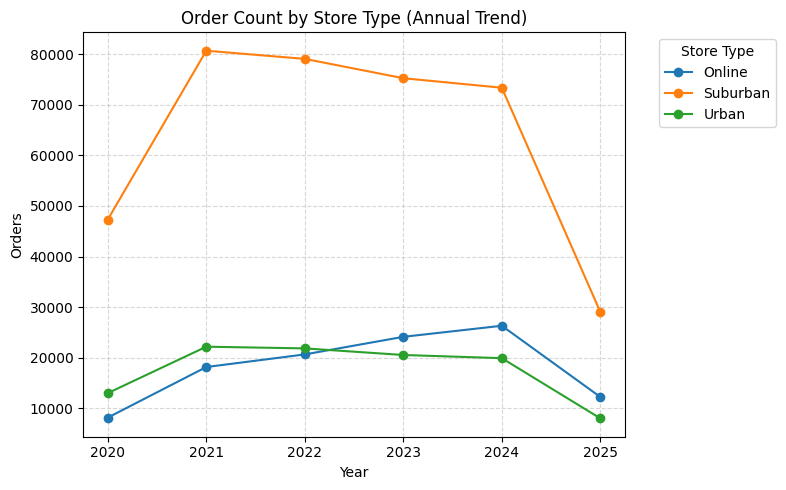

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# 1️⃣  Add Year column
df_y = df.withColumn("Year", F.year("Transaction_Timestamp"))

# 2️⃣  Order count by Year & Store_Type
orders_store_year = (
    df_y.groupBy("Year", "Store_Type")
        .agg(F.count("*").alias("Orders"))
        .orderBy("Year", "Store_Type")
)

display(orders_store_year)      # Spark table for exact numbers

# 3️⃣  Pivot to pandas for plotting
pd_osy = orders_store_year.toPandas()
pivot = pd_osy.pivot(index="Year", columns="Store_Type", values="Orders").fillna(0)

# 4️⃣  Plot
pivot.plot(marker="o", figsize=(8,5))
plt.title("Order Count by Store Type (Annual Trend)")
plt.xlabel("Year")
plt.ylabel("Orders")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Store Type", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()


/databricks/python/lib/python3.11/site-packages/pyspark/sql/connect/expressions.py:1017: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


Year,AOV,Avg_Unit_Price,AOV_YoY_%,PriceIndex_YoY_%
2020,140.95666875939884,64.11862040268137,null,null
2021,144.60831539204855,65.80881851904105,2.5906164389304407,2.636048788549729
2022,155.20906410383188,71.21202584221666,7.330663304557255,8.210460915070598
2023,161.73956377461894,73.9109764211446,4.2075504471944285,3.7900207823155547
2024,165.68384835970306,75.47126701333944,2.438664043004596,2.111040426937825
2025,167.81883118462173,76.89961100299244,1.2885883844776311,1.8925665967692624



Pearson correlation of YoY AOV vs Unit-Price index: 0.99



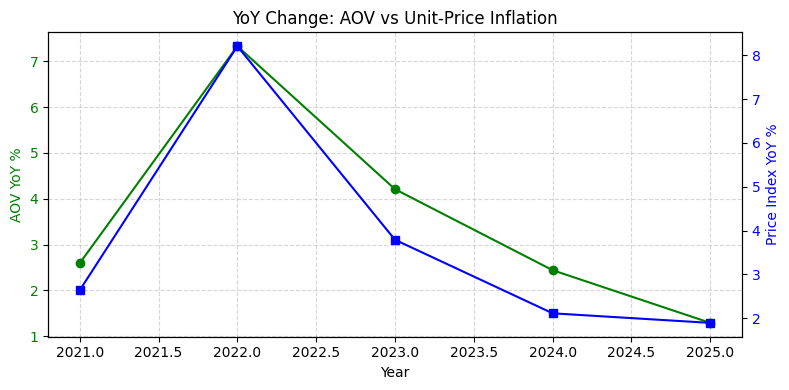

/databricks/python/lib/python3.11/site-packages/pyspark/sql/connect/expressions.py:1017: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


In [0]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt


# -----------------------------
# 1. Add Year column
df_y = df.withColumn("Year", F.year("Transaction_Timestamp"))

# -----------------------------
# 2. Annual AOV and Unit-Price index
kpi = (
    df_y.groupBy("Year")
        .agg(
            F.avg("Total_Price").alias("AOV"),          # average revenue per order
            F.avg("Unit_Price").alias("Avg_Unit_Price") # average list price across SKUs sold
        )
        .orderBy("Year")
)

# 3. Compute YoY % change for both metrics
w = Window.orderBy("Year")
kpi_yoy = (
    kpi.withColumn("AOV_YoY_%",
                   (F.col("AOV") - F.lag("AOV").over(w))
                   / F.lag("AOV").over(w) * 100)
        .withColumn("PriceIndex_YoY_%",
                   (F.col("Avg_Unit_Price") - F.lag("Avg_Unit_Price").over(w))
                   / F.lag("Avg_Unit_Price").over(w) * 100)
)

display(kpi_yoy)    # inspect exact numbers

# -----------------------------
# 4. Correlation coefficient (Pearson)
corr = kpi_yoy.stat.corr("AOV_YoY_%", "PriceIndex_YoY_%")
print(f"\nPearson correlation of YoY AOV vs Unit-Price index: {corr:.2f}\n")

# -----------------------------
# 5. Dual-axis line plot
pd_kpi = kpi_yoy.toPandas()
fig, ax1 = plt.subplots(figsize=(8,4))

ax1.plot(pd_kpi["Year"], pd_kpi["AOV_YoY_%"], marker="o",
         color="green", label="AOV YoY %")
ax1.set_ylabel("AOV YoY %", color="green")
ax1.tick_params(axis="y", labelcolor="green")
ax1.set_xlabel("Year")

ax2 = ax1.twinx()
ax2.plot(pd_kpi["Year"], pd_kpi["PriceIndex_YoY_%"], marker="s",
         color="blue", label="Avg Unit Price YoY %")
ax2.set_ylabel("Price Index YoY %", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

plt.title("YoY Change: AOV vs Unit-Price Inflation")
ax1.grid(True, ls="--", alpha=.5)
fig.tight_layout()
plt.show()


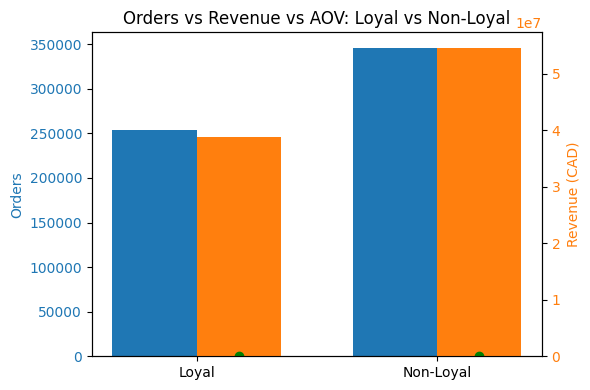

In [0]:
import numpy as np
fig, ax1 = plt.subplots(figsize=(6,4))

x = np.arange(len(pd_loyal))           # positions [0,1]
width = 0.35

# left axis – Orders
ax1.bar(x - width/2, pd_loyal["Orders"], width, color="#1f77b4", label="Orders")
ax1.set_ylabel("Orders", color="#1f77b4")
ax1.tick_params(axis='y', labelcolor="#1f77b4")

# right axis – Revenue
ax2 = ax1.twinx()
ax2.bar(x + width/2, pd_loyal["Revenue_CAD"], width, color="#ff7f0e", label="Revenue")
ax2.set_ylabel("Revenue (CAD)", color="#ff7f0e")
ax2.tick_params(axis='y', labelcolor="#ff7f0e")

# AOV markers
for i, row in pd_loyal.iterrows():
    ax2.plot(i + width/2, row["AOV_CAD"], marker="o", color="green")

ax1.set_xticks(x)
ax1.set_xticklabels(pd_loyal["Segment"])
ax1.set_title("Orders vs Revenue vs AOV: Loyal vs Non-Loyal")
plt.tight_layout()
plt.show()


Year,Loyalty_Member,Orders,AOV_CAD
2020,false,39443,142.33700479172572
2020,true,29048,139.0823712475918
2021,false,69905,146.92307002360138
2021,true,51138,141.444075051818
2022,false,70075,157.17020563682172
2022,true,51509,152.54104506008892
2023,false,69140,163.39436635810796
2023,true,50798,159.4872496948757
2024,false,69095,168.01029510094585
2024,true,50517,162.50183364016215


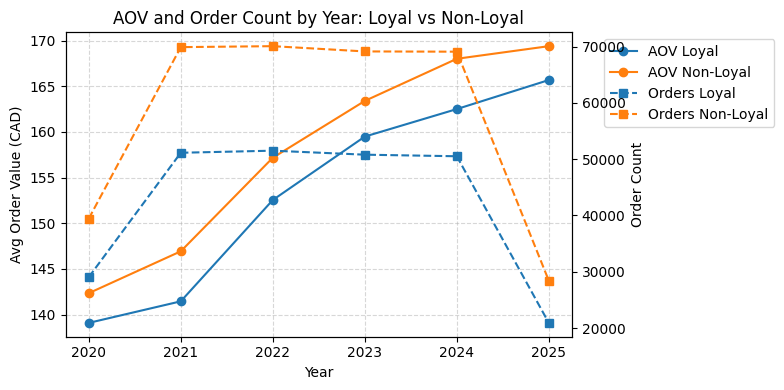

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# 1️⃣ Add Year column
df_y = df.withColumn("Year", F.year("Transaction_Timestamp"))

# 2️⃣ Aggregate Orders and AOV by Year & Loyalty
agg_loyal_year = (
    df_y.groupBy("Year", "Loyalty_Member")
        .agg(
            F.count("*").alias("Orders"),
            F.avg("Total_Price").alias("AOV_CAD")
        )
        .orderBy("Year", "Loyalty_Member")
)

display(agg_loyal_year)   # Spark table to inspect exact numbers

# 3️⃣ Convert to pandas & pivot into two separate tables
pd_agg = agg_loyal_year.toPandas()
pd_agg["Segment"] = pd_agg["Loyalty_Member"].map({True: "Loyal", False: "Non-Loyal"})

pivot_aov    = pd_agg.pivot(index="Year", columns="Segment", values="AOV_CAD").fillna(0)
pivot_orders = pd_agg.pivot(index="Year", columns="Segment", values="Orders").fillna(0)

# 4️⃣ Plot
fig, ax1 = plt.subplots(figsize=(8,4))

# AOV lines (solid) on left axis
ax1.plot(pivot_aov.index, pivot_aov["Loyal"],     marker="o", color="#1f77b4", label="AOV Loyal")
ax1.plot(pivot_aov.index, pivot_aov["Non-Loyal"], marker="o", color="#ff7f0e", label="AOV Non-Loyal")
ax1.set_ylabel("Avg Order Value (CAD)")
ax1.set_xlabel("Year")
ax1.grid(True, ls="--", alpha=.5)

# Order-count lines (dashed) on right axis
ax2 = ax1.twinx()
ax2.plot(pivot_orders.index, pivot_orders["Loyal"],     marker="s", ls="--", color="#1f77b4",  label="Orders Loyal")
ax2.plot(pivot_orders.index, pivot_orders["Non-Loyal"], marker="s", ls="--", color="#ff7f0e",  label="Orders Non-Loyal")
ax2.set_ylabel("Order Count")

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2,labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper left", bbox_to_anchor=(1.05,1))

plt.title("AOV and Order Count by Year: Loyal vs Non-Loyal")
plt.tight_layout()
plt.show()


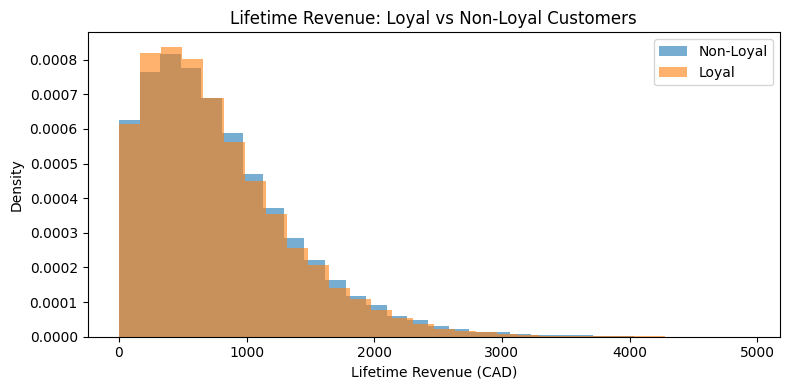

In [0]:
# 1. Calculate lifetime revenue per customer
ltv = (df.groupBy("Customer_ID", "Loyalty_Member")
         .agg(F.sum("Total_Price").alias("Lifetime_Revenue")))

# 2. Convert to pandas
pd_ltv = ltv.toPandas()
pd_ltv["Segment"] = pd_ltv["Loyalty_Member"].map({True: "Loyal", False: "Non-Loyal"})

# 3. Plot histogram
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
for segment, color in [("Non-Loyal", "#1f77b4"), ("Loyal", "#ff7f0e")]:
    subset = pd_ltv[pd_ltv["Segment"] == segment]["Lifetime_Revenue"]
    plt.hist(subset, bins=30, alpha=0.6, label=segment, color=color, density=True)

plt.title("Lifetime Revenue: Loyal vs Non-Loyal Customers")
plt.xlabel("Lifetime Revenue (CAD)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()
